In [188]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# google cloud packages
from google.cloud import storage
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

# install google cloud storage library
!pip install google-cloud-storage

# authenticate with google cloud storage
auth.authenticate_user()

In [189]:
# setup code for use with google cloud storage and bigquery

# google cloud project setup
project_id = "mimic-project-451516"

# instantiate client for  google cloud storage
gcs_client = storage.Client(project=project_id)

# instantiate client for big query
bq_client = bigquery.Client(project=project_id)

# instantiate MIMIC-III storage bucket
bucket_name = "mimiciii-1.4.physionet.org"

In [190]:
# check available files in the bucket by printing list of files
print(f"Files in GCS bucket: {bucket_name}")

# instantiate bucket and store files in blob
gcs_bucket = gcs_client.bucket(bucket_name, user_project=project_id)
blobs = gcs_bucket.list_blobs()
file_list = [blob.name for blob in blobs]

# format so that files and their list index are present for quick access later
df_files = pd.DataFrame({
    "Index": range(len(file_list)),
    "Filename": file_list
})

# filter only on csv files that contain patient data
df_files = df_files[df_files['Filename'].str.endswith('.csv.gz')]

print(df_files.to_string(index=False))

Files in GCS bucket: mimiciii-1.4.physionet.org
 Index                  Filename
     0         ADMISSIONS.csv.gz
     1            CALLOUT.csv.gz
     2         CAREGIVERS.csv.gz
     3        CHARTEVENTS.csv.gz
     4          CPTEVENTS.csv.gz
     5     DATETIMEEVENTS.csv.gz
     6      DIAGNOSES_ICD.csv.gz
     7           DRGCODES.csv.gz
     8              D_CPT.csv.gz
     9    D_ICD_DIAGNOSES.csv.gz
    10   D_ICD_PROCEDURES.csv.gz
    11            D_ITEMS.csv.gz
    12         D_LABITEMS.csv.gz
    13           ICUSTAYS.csv.gz
    14     INPUTEVENTS_CV.csv.gz
    15     INPUTEVENTS_MV.csv.gz
    16          LABEVENTS.csv.gz
    18 MICROBIOLOGYEVENTS.csv.gz
    19         NOTEEVENTS.csv.gz
    20       OUTPUTEVENTS.csv.gz
    21           PATIENTS.csv.gz
    22      PRESCRIPTIONS.csv.gz
    23 PROCEDUREEVENTS_MV.csv.gz
    24     PROCEDURES_ICD.csv.gz
    26           SERVICES.csv.gz
    28          TRANSFERS.csv.gz


In [191]:
# define function to load each csv file either by downloading or using bigquery query
def load_file_results_to_df(file_path=None, query=None, bucket=gcs_bucket, client=None):

    # load csv file directly from google cloud storage (for files that are smaller)
    if file_path:
        blob = bucket.blob(file_path)
        blob.download_to_filename(file_path)
        print(f"Download complete: {file_path}")
        df = pd.read_csv(file_path, compression="gzip")

    # load csv file after applying query using bigquery (for larger files)
    elif query:
        df = bq_client.query(query).to_dataframe()
        print("Query executed and loaded to DataFrame using BigQuery")

    # count number of rows in dataframe and print message
    row_count = len(df)
    print(f"DataFrame with {row_count} row(s) has been returned.")

    return df

In [192]:
# load admissions dataframe to memory and print first rows
admissions_df = load_file_results_to_df(file_path=file_list[0])
admissions_df.head(10)

Download complete: ADMISSIONS.csv.gz
DataFrame with 58976 row(s) has been returned.


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1


In [193]:
# load patients dataframe to memory and print first rows
patients_df = load_file_results_to_df(file_path=file_list[21])
patients_df.head(10)

Download complete: PATIENTS.csv.gz
DataFrame with 46520 row(s) has been returned.


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
5,239,255,M,2109-08-05 00:00:00,NaN,NaN,NaN,0
6,240,256,M,2086-07-31 00:00:00,NaN,NaN,NaN,0
7,241,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,1
8,242,258,F,2124-09-19 00:00:00,NaN,NaN,NaN,0
9,243,260,F,2105-03-23 00:00:00,NaN,NaN,NaN,0


In [194]:
# merge and drop unnecessary columns
joined_admissions_patients_df = admissions_df.merge(patients_df, on='SUBJECT_ID', how='left')
joined_admissions_patients_df = joined_admissions_patients_df.drop(columns=['ROW_ID_x', 'ROW_ID_y'])

In [195]:
joined_admissions_patients_df.info()
joined_admissions_patients_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBJECT_ID            58976 non-null  int64 
 1   HADM_ID               58976 non-null  int64 
 2   ADMITTIME             58976 non-null  object
 3   DISCHTIME             58976 non-null  object
 4   DEATHTIME             5854 non-null   object
 5   ADMISSION_TYPE        58976 non-null  object
 6   ADMISSION_LOCATION    58976 non-null  object
 7   DISCHARGE_LOCATION    58976 non-null  object
 8   INSURANCE             58976 non-null  object
 9   LANGUAGE              33644 non-null  object
 10  RELIGION              58518 non-null  object
 11  MARITAL_STATUS        48848 non-null  object
 12  ETHNICITY             58976 non-null  object
 13  EDREGTIME             30877 non-null  object
 14  EDOUTTIME             30877 non-null  object
 15  DIAGNOSIS             58951 non-null

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,F,2131-05-07 00:00:00,NaN,NaN,NaN,0
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,M,2100-05-31 00:00:00,NaN,NaN,NaN,0
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,M,2101-11-21 00:00:00,NaN,NaN,NaN,0
5,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,M,2054-05-04 00:00:00,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1
6,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,F,2191-11-30 00:00:00,NaN,NaN,NaN,0
7,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2103-04-15 00:00:00,NaN,NaN,NaN,0
8,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,M,1872-10-14 00:00:00,NaN,NaN,NaN,0
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1,M,2036-05-17 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1


In [196]:
# drop duplicates
joined_admissions_patients_df = joined_admissions_patients_df.drop_duplicates()

In [197]:
# show all columns present in resulting dataframe
joined_admissions_patients_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG',
       'HAS_CHARTEVENTS_DATA', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

In [198]:
# remove unneeded columns
joined_admissions_patients_df.drop(columns=['DISCHTIME', 'DEATHTIME','EDREGTIME',
                                            'HOSPITAL_EXPIRE_FLAG', 'DISCHARGE_LOCATION', 'HAS_CHARTEVENTS_DATA',
                                            'EDOUTTIME','DOD', 'DOD_HOSP', 'DOD_SSN', 'DIAGNOSIS'], inplace=True)
joined_admissions_patients_df.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,DOB,EXPIRE_FLAG
0,22,165315,2196-04-09 12:26:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,F,2131-05-07 00:00:00,0
1,23,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2082-07-17 00:00:00,0
2,23,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,2082-07-17 00:00:00,0
3,24,161859,2139-06-06 16:14:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,M,2100-05-31 00:00:00,0
4,25,129635,2160-11-02 02:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,M,2101-11-21 00:00:00,0
5,26,197661,2126-05-06 15:16:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,M,2054-05-04 00:00:00,1
6,27,134931,2191-11-30 22:16:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,NaN,CATHOLIC,NaN,WHITE,F,2191-11-30 00:00:00,0
7,28,162569,2177-09-01 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2103-04-15 00:00:00,0
8,30,104557,2172-10-14 14:17:00,URGENT,TRANSFER FROM HOSP/EXTRAM,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,M,1872-10-14 00:00:00,0
9,31,128652,2108-08-22 23:27:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2036-05-17 00:00:00,1


In [199]:
# convert columns to datetime
joined_admissions_patients_df["ADMITTIME"] = pd.to_datetime(joined_admissions_patients_df["ADMITTIME"])
joined_admissions_patients_df["DOB"] = pd.to_datetime(joined_admissions_patients_df["DOB"])

In [200]:
# calculate age in years as new column
joined_admissions_patients_df['DOB_PY'] = joined_admissions_patients_df['DOB'].apply(lambda x: x.to_pydatetime())
joined_admissions_patients_df['ADMITTIME_PY'] = joined_admissions_patients_df['ADMITTIME'].apply(lambda x: x.to_pydatetime())

joined_admissions_patients_df['DOB_ORD'] = joined_admissions_patients_df['DOB_PY'].apply(lambda x: x.toordinal())
joined_admissions_patients_df['ADMITTIME_ORD'] = joined_admissions_patients_df['ADMITTIME_PY'].apply(lambda x: x.toordinal())

joined_admissions_patients_df['AGE_DAYS'] = joined_admissions_patients_df['ADMITTIME_ORD'] - joined_admissions_patients_df['DOB_ORD']
joined_admissions_patients_df['AGE_YEARS'] = (joined_admissions_patients_df['AGE_DAYS'] / 365.25).astype(int)

# remove unnecessary columns now that age feature has been engineered
joined_admissions_patients_df.drop(columns=['DOB', 'DOB_PY', 'ADMITTIME_PY',
                                            'DOB_ORD', 'ADMITTIME_ORD', 'AGE_DAYS'], inplace=True)

In [201]:
# group admission locations and filter out HMO REFERRAL/SICK which has low number of samples
joined_admissions_patients_df['ADMISSION_LOCATION'] = joined_admissions_patients_df['ADMISSION_LOCATION'].apply(
    lambda x: "TRANSFER" if ('TRANSFER' in x or 'TRSF' in x) else
    "UNKNOWN" if ('INFO NOT AVAILABLE' in x) else x
)
# print distribution
print(joined_admissions_patients_df['ADMISSION_LOCATION'].value_counts())

ADMISSION_LOCATION
EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER                      8805
UNKNOWN                        204
HMO REFERRAL/SICK              102
Name: count, dtype: int64


In [202]:
# group chinese languages
joined_admissions_patients_df['LANGUAGE'] = joined_admissions_patients_df['LANGUAGE'].apply(
    lambda x: "CHIN" if x in ['CANT', 'MAND'] else x
)

#  print language distribution
language_counts = joined_admissions_patients_df['LANGUAGE'].value_counts()
print(language_counts)

LANGUAGE
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CHIN      569
PORT      342
CAPE      256
HAIT      150
ITAL      124
VIET       94
GREE       75
ARAB       47
PERS       44
CAMB       37
POLI       34
AMER       31
HIND       24
KORE       23
ALBA       17
FREN       16
SOMA       13
THAI       12
ETHI       11
*ARM        9
*CHI        7
LAOT        7
*YID        7
*BEN        7
*HUN        7
*GUJ        7
URDU        5
*BUL        5
*CDI        4
*IBO        4
*URD        4
*BUR        4
*MAN        3
**TO        3
*TEL        3
TAGA        3
JAPA        3
*FUL        2
**SH        2
BENG        2
*TOI        2
TURK        2
*AMH        2
*TOY        2
*LEB        2
*CAN        2
* BE        2
*KHM        2
*DUT        2
*MOR        2
*DEA        1
*SPA        1
*PHI        1
*PUN        1
*RUS        1
*ROM        1
GERM        1
*BOS        1
*YOR        1
*ARA        1
*FAR        1
* FU        1
SERB        1
** T        1
*CRE        1
*NEP        1
*FIL       

In [203]:
# languages to mark as other
other_languages = language_counts[language_counts <= 300]
# replace languages with other
joined_admissions_patients_df['LANGUAGE'] = joined_admissions_patients_df['LANGUAGE'].apply(
    lambda x: "OTHER" if x in other_languages else x
)

# print language distribution
print(joined_admissions_patients_df['LANGUAGE'].value_counts())

LANGUAGE
ENGL     29086
OTHER     1146
SPAN      1083
RUSS       790
PTUN       628
CHIN       569
PORT       342
Name: count, dtype: int64


In [204]:
# define religion categories
christian_religion = ['CATHOLIC', 'PROTESTANT QUAKER', 'EPISCOPALIAN', 'GREEK ORTHODOX', 'CHRISTIAN SCIENTIST', '7TH DAY ADVENTIST', 'BAPTIST', 'METHODIST', 'LUTHERAN', 'ROMANIAN EAST. ORTH']
jewish_religion = ['JEWISH', 'HEBREW']
other_religion = ['JEHOVAH\'S WITNESS', 'UNITARIAN-UNIVERSALIST', 'NOT SPECIFIED', 'UNOBTAINABLE', 'OTHER']

# group religions
joined_admissions_patients_df['RELIGION'] = joined_admissions_patients_df['RELIGION'].apply(
    lambda x: "CHRISTIAN" if x in christian_religion else
    "JEWISH" if x in jewish_religion else
    "OTHER" if x in other_religion else x
)

# print religion distribution
print(joined_admissions_patients_df['RELIGION'].value_counts())

RELIGION
CHRISTIAN    29602
OTHER        22981
JEWISH        5330
BUDDHIST       267
MUSLIM         225
HINDU          113
Name: count, dtype: int64


In [205]:
# group marital statuses
joined_admissions_patients_df['MARITAL_STATUS'] = joined_admissions_patients_df['MARITAL_STATUS'].apply(
    lambda x: "OTHER" if x in ['WIDOWED', 'DIVORCED', 'SEPARATED'] else
    "MARRIED" if x == "LIFE PARTNER" else
    "UNKNOWN" if x == "UNKNOWN (DEFAULT)" else x
)

# print marital status distribution
print(joined_admissions_patients_df['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED    24254
SINGLE     13254
OTHER      10995
UNKNOWN      345
Name: count, dtype: int64


In [206]:
# print ethnicity distribution
ethnicity_counts = joined_admissions_patients_df['ETHNICITY'].value_counts()
print(ethnicity_counts)

ETHNICITY
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [207]:
# ethnicities to mark as other
other_ethnicities = ethnicity_counts[ethnicity_counts <= 150]
# unknown ethnicities
unknown_ethnicites = ['UNKNOWN/NOT SPECIFIED', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# group ethnicities where applicable into new column using broader grouping, otherwise group into other
joined_admissions_patients_df['ETHNICITY'] = joined_admissions_patients_df['ETHNICITY'].apply(
    lambda x: 'ASIAN' if 'ASIAN' in str(x) else (
        'BLACK' if 'BLACK' in str(x) else (
            'HISPANIC OR LATINO' if ('HISPANIC/LATINO' in str(x)) else
        'WHITE' if 'WHITE' in str(x) else
        "UNKNOWN" if x in unknown_ethnicites else
            "OTHER" if x in other_ethnicities else
            x
        )
    )
)

# print ethnicity distribution
print(joined_admissions_patients_df['ETHNICITY'].value_counts())

ETHNICITY
WHITE                 41325
UNKNOWN                5896
BLACK                  5785
HISPANIC OR LATINO     2128
ASIAN                  2007
OTHER                  1835
Name: count, dtype: int64


In [208]:
# some patients have multiple HADM_IDs - but a lower HADM_ID number isn't necessarily representative of a earlier admit time / first arrival into hospital
# keep only rows where patient has presented for the first time

patients_first_visit_df = joined_admissions_patients_df.loc[
    joined_admissions_patients_df.groupby('SUBJECT_ID')['ADMITTIME'].idxmin()
]
patients_first_visit_df.info()
patients_first_visit_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 46520 entries, 211 to 56566
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          46520 non-null  int64         
 1   HADM_ID             46520 non-null  int64         
 2   ADMITTIME           46520 non-null  datetime64[ns]
 3   ADMISSION_TYPE      46520 non-null  object        
 4   ADMISSION_LOCATION  46520 non-null  object        
 5   INSURANCE           46520 non-null  object        
 6   LANGUAGE            24370 non-null  object        
 7   RELIGION            46077 non-null  object        
 8   MARITAL_STATUS      36740 non-null  object        
 9   ETHNICITY           46520 non-null  object        
 10  GENDER              46520 non-null  object        
 11  EXPIRE_FLAG         46520 non-null  int64         
 12  AGE_YEARS           46520 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(8)
memory 

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,EXPIRE_FLAG,AGE_YEARS
211,2,163353,2138-07-17 19:04:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,NaN,OTHER,NaN,ASIAN,M,0,0
212,3,145834,2101-10-20 19:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,NaN,CHRISTIAN,MARRIED,WHITE,M,1,76
213,4,185777,2191-03-16 00:28:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,CHRISTIAN,SINGLE,WHITE,F,0,47
214,5,178980,2103-02-02 04:31:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,NaN,BUDDHIST,NaN,ASIAN,M,0,0
215,6,107064,2175-05-30 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,ENGL,OTHER,MARRIED,WHITE,F,0,65
216,7,118037,2121-05-23 15:05:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,NaN,CHRISTIAN,NaN,WHITE,F,0,0
217,8,159514,2117-11-20 10:22:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,NaN,CHRISTIAN,NaN,WHITE,M,0,0
218,9,150750,2149-11-09 13:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,NaN,OTHER,NaN,UNKNOWN,M,1,41
219,10,184167,2103-06-28 11:36:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Medicaid,NaN,OTHER,NaN,BLACK,F,0,0
220,11,194540,2178-04-16 06:18:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,OTHER,MARRIED,WHITE,F,1,50


In [209]:
# check for duplicate subject_id
duplicate_subject_id_count = patients_first_visit_df.duplicated(subset=['SUBJECT_ID']).sum()
print(f"Number of duplicate SUBJECT_IDs is: {duplicate_subject_id_count}")

# check for diplicate hadm_id
duplicate_hadm_id_count = patients_first_visit_df.duplicated(subset=['HADM_ID']).sum()
print(f"Number of duplicate HADM_IDs is: {duplicate_hadm_id_count}")

Number of duplicate SUBJECT_IDs is: 0
Number of duplicate HADM_IDs is: 0


In [210]:
adult_patients_first_visit_df = patients_first_visit_df[(patients_first_visit_df['AGE_YEARS'] >= 18) & (patients_first_visit_df['AGE_YEARS'] <= 90)]

In [211]:
nullvalues = adult_patients_first_visit_df.isnull().sum()
print(nullvalues)

SUBJECT_ID                0
HADM_ID                   0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
LANGUAGE              13798
RELIGION                411
MARITAL_STATUS         2085
ETHNICITY                 0
GENDER                    0
EXPIRE_FLAG               0
AGE_YEARS                 0
dtype: int64


In [212]:
adult_patients_first_visit_df['LANGUAGE'] = adult_patients_first_visit_df['LANGUAGE'].fillna('UKNO')
adult_patients_first_visit_df['RELIGION'] = adult_patients_first_visit_df['RELIGION'].fillna('UNKNOWN')
adult_patients_first_visit_df['MARITAL_STATUS'] = adult_patients_first_visit_df['MARITAL_STATUS'].fillna('UNKNOWN')

/tmp/ipython-input-212-198598477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_patients_first_visit_df['LANGUAGE'] = adult_patients_first_visit_df['LANGUAGE'].fillna('UKNO')
/tmp/ipython-input-212-198598477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_patients_first_visit_df['RELIGION'] = adult_patients_first_visit_df['RELIGION'].fillna('UNKNOWN')
/tmp/ipython-input-212-198598477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [213]:
# check final null values for core dataset
coredataset_nullvalues = adult_patients_first_visit_df.isnull().sum()
print(coredataset_nullvalues)

SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ADMISSION_LOCATION    0
INSURANCE             0
LANGUAGE              0
RELIGION              0
MARITAL_STATUS        0
ETHNICITY             0
GENDER                0
EXPIRE_FLAG           0
AGE_YEARS             0
dtype: int64


In [214]:
# store final dataframe ready for use later
final_patients_df = adult_patients_first_visit_df.reset_index(drop=True)
final_admissions_patients_df = final_patients_df
final_admissions_patients_df.info()
final_admissions_patients_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36557 entries, 0 to 36556
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          36557 non-null  int64         
 1   HADM_ID             36557 non-null  int64         
 2   ADMITTIME           36557 non-null  datetime64[ns]
 3   ADMISSION_TYPE      36557 non-null  object        
 4   ADMISSION_LOCATION  36557 non-null  object        
 5   INSURANCE           36557 non-null  object        
 6   LANGUAGE            36557 non-null  object        
 7   RELIGION            36557 non-null  object        
 8   MARITAL_STATUS      36557 non-null  object        
 9   ETHNICITY           36557 non-null  object        
 10  GENDER              36557 non-null  object        
 11  EXPIRE_FLAG         36557 non-null  int64         
 12  AGE_YEARS           36557 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(8)
memo

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,EXPIRE_FLAG,AGE_YEARS
0,3,145834,2101-10-20 19:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,UKNO,CHRISTIAN,MARRIED,WHITE,M,1,76
1,4,185777,2191-03-16 00:28:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,UKNO,CHRISTIAN,SINGLE,WHITE,F,0,47
2,6,107064,2175-05-30 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,ENGL,OTHER,MARRIED,WHITE,F,0,65
3,9,150750,2149-11-09 13:06:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,UKNO,OTHER,UNKNOWN,UNKNOWN,M,1,41
4,11,194540,2178-04-16 06:18:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,UKNO,OTHER,MARRIED,WHITE,F,1,50
5,12,112213,2104-08-07 10:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,UKNO,JEWISH,MARRIED,WHITE,M,1,72
6,13,143045,2167-01-08 18:43:00,EMERGENCY,TRANSFER,Medicaid,UKNO,OTHER,UNKNOWN,WHITE,F,0,39
7,17,194023,2134-12-27 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,ENGL,CHRISTIAN,MARRIED,WHITE,F,0,47
8,18,188822,2167-10-02 11:18:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,Private,UKNO,CHRISTIAN,MARRIED,WHITE,M,0,50
9,20,157681,2183-04-28 09:45:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,UKNO,CHRISTIAN,OTHER,WHITE,F,0,75


In [215]:
# separate identifiers required for matching in remaining datasets, ADMITTIME needed for filtering
patient_identifiers_df = final_admissions_patients_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']]

In [216]:
# set up required to upload patient patients to bigquery for quicker query using SQL
dataset_id = 'mimic_temp_datasets'
table_id = 'patient_identifiers'
full_dataset_path = f"{project_id}.{dataset_id}.{table_id}"
print("Patient Identifiers will be stored at: " + full_dataset_path)

Patient Identifiers will be stored at: mimic-project-451516.mimic_temp_datasets.patient_identifiers


In [217]:
# load patient identifiers to big query
job = bq_client.load_table_from_dataframe(patient_identifiers_df, full_dataset_path)
job.result()

LoadJob<project=mimic-project-451516, location=US, id=3db9bce5-fcf5-4936-84ae-ecb89926996d>

ADMINISTRATIVE DATASETS

CALLOUT DATASET

In [218]:
# SQL query to select rows from callout dataset based on SUBJECT_IDs and HADM_IDs within 48 hour window

callout_query = f"""
SELECT t.*
FROM `physionet-data.mimiciii_clinical.callout` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CREATETIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
"""

In [219]:
# load callout dataframe from bigquery
callout_df = load_file_results_to_df(query=callout_query, bucket=gcs_bucket, client=bq_client)
# drop duplicates
callout_df = callout_df.drop_duplicates()

Query executed and loaded to DataFrame using BigQuery
DataFrame with 31380 row(s) has been returned.


In [220]:
callout_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,REQUEST_RESP,REQUEST_CDIFF,REQUEST_MRSA,REQUEST_VRE,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,1010,2574,179700,14,None,24,TSICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Revised,2133-11-27 10:20:13,2133-11-28 17:20:58,NaT,2133-11-28 17:25:02,NaT,NaT
3,4487,11505,162933,14,None,24,TSICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2175-02-14 08:25:58,2175-02-14 08:25:58,2175-02-14 08:31:04,2175-02-14 18:10:04,NaT,NaT
6,34116,98734,123336,14,None,24,TSICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2146-10-04 08:40:52,2146-10-04 08:40:52,2146-10-04 09:01:28,2146-10-04 14:25:04,2146-10-04 09:25:05,NaT
9,869,2150,189980,33,None,24,SICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2137-08-15 15:44:38,2137-08-15 15:44:38,2137-08-15 15:55:34,2137-08-16 14:55:02,NaT,NaT
12,2291,5761,183840,33,None,24,SICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2126-12-14 09:56:00,2126-12-14 09:56:00,2126-12-14 13:37:49,2126-12-14 15:40:03,NaT,NaT
15,3801,9779,110839,33,None,24,SICU,18,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2134-12-24 09:11:27,2134-12-24 09:11:27,2134-12-24 09:34:51,2134-12-25 17:55:02,NaT,NaT
18,3945,10122,114781,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2129-03-19 14:29:42,2129-03-19 14:29:42,2129-03-19 15:02:08,2129-03-20 20:55:04,NaT,NaT
21,10623,27053,182434,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2135-12-11 09:07:49,2135-12-11 09:07:49,2135-12-11 09:30:50,2135-12-11 11:25:02,NaT,NaT
24,18288,47818,197407,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2198-04-24 13:02:01,2198-04-24 13:02:01,2198-04-24 13:12:33,2198-04-24 17:25:10,2198-04-24 13:40:09,NaT
27,34487,99965,101083,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2191-07-15 10:25:14,2191-07-15 10:25:14,2191-07-15 10:25:27,2191-07-15 13:25:04,2191-07-15 10:55:06,NaT


In [221]:
# cast datetime values to datetime
callout_df['CREATETTIME'] = pd.to_datetime(callout_df['CREATETIME'])
callout_df['OUTCOMETIME'] = pd.to_datetime(callout_df['OUTCOMETIME'])

In [222]:
# calculate callout time length of callout request
# callout_df['CALLOUT_LENGTH_HRS'] = (callout_df['OUTCOMETIME'] - callout_df['CREATETIME']).dt.total_seconds() / 3600

# identify cancelled callout requests
callout_df['CANCELLED'] = callout_df['CALLOUT_OUTCOME'].astype(str).str.upper().str.contains('CANCELLED', na=False)

# store boolean for types of requests within first 48 hours of admission
callout_df['TELE_REQUEST'] = callout_df['REQUEST_TELE'].astype(bool)
callout_df['RESP_REQUEST'] = callout_df['REQUEST_RESP'].astype(bool)
callout_df['CDIFF_REQUEST'] = callout_df['REQUEST_CDIFF'].astype(bool)
callout_df['MRSA_REQUEST'] = callout_df['REQUEST_MRSA'].astype(bool)
callout_df['VRE_REQUEST'] = callout_df['REQUEST_VRE'].astype(bool)

In [223]:
callout_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,REQUEST_RESP,REQUEST_CDIFF,REQUEST_MRSA,REQUEST_VRE,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME,CREATETTIME,CANCELLED,TELE_REQUEST,RESP_REQUEST,CDIFF_REQUEST,MRSA_REQUEST,VRE_REQUEST
0,1010,2574,179700,14,None,24,TSICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Revised,2133-11-27 10:20:13,2133-11-28 17:20:58,NaT,2133-11-28 17:25:02,NaT,NaT,2133-11-27 10:20:13,False,False,False,False,False,False
3,4487,11505,162933,14,None,24,TSICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2175-02-14 08:25:58,2175-02-14 08:25:58,2175-02-14 08:31:04,2175-02-14 18:10:04,NaT,NaT,2175-02-14 08:25:58,False,False,False,False,False,False
6,34116,98734,123336,14,None,24,TSICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2146-10-04 08:40:52,2146-10-04 08:40:52,2146-10-04 09:01:28,2146-10-04 14:25:04,2146-10-04 09:25:05,NaT,2146-10-04 08:40:52,False,False,False,False,False,False
9,869,2150,189980,33,None,24,SICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2137-08-15 15:44:38,2137-08-15 15:44:38,2137-08-15 15:55:34,2137-08-16 14:55:02,NaT,NaT,2137-08-15 15:44:38,False,False,False,False,False,False
12,2291,5761,183840,33,None,24,SICU,1,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2126-12-14 09:56:00,2126-12-14 09:56:00,2126-12-14 13:37:49,2126-12-14 15:40:03,NaT,NaT,2126-12-14 09:56:00,False,False,False,False,False,False
15,3801,9779,110839,33,None,24,SICU,18,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2134-12-24 09:11:27,2134-12-24 09:11:27,2134-12-24 09:34:51,2134-12-25 17:55:02,NaT,NaT,2134-12-24 09:11:27,False,False,False,False,False,False
18,3945,10122,114781,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2129-03-19 14:29:42,2129-03-19 14:29:42,2129-03-19 15:02:08,2129-03-20 20:55:04,NaT,NaT,2129-03-19 14:29:42,False,False,False,False,False,False
21,10623,27053,182434,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2135-12-11 09:07:49,2135-12-11 09:07:49,2135-12-11 09:30:50,2135-12-11 11:25:02,NaT,NaT,2135-12-11 09:07:49,False,False,False,False,False,False
24,18288,47818,197407,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2198-04-24 13:02:01,2198-04-24 13:02:01,2198-04-24 13:12:33,2198-04-24 17:25:10,2198-04-24 13:40:09,NaT,2198-04-24 13:02:01,False,False,False,False,False,False
27,34487,99965,101083,33,None,24,SICU,24,GU,0,0,0,0,0,Inactive,Discharged,24,Acknowledged,2191-07-15 10:25:14,2191-07-15 10:25:14,2191-07-15 10:25:27,2191-07-15 13:25:04,2191-07-15 10:55:06,NaT,2191-07-15 10:25:14,False,False,False,False,False,False


In [224]:
# aggregate callout dataset using new columns for desired features
final_callout_df = callout_df.groupby('HADM_ID').agg(
    TOTAL_NO_CALLOUTS=('ROW_ID', 'count'),
    CANCELLED_CALLOUTS=('CANCELLED', 'sum'),
    MRSA_REQ_MADE=('MRSA_REQUEST', 'any'),
    TELE_REQ_MADE=('TELE_REQUEST', 'any'),
    RESP_REQ_MADE=('RESP_REQUEST', 'any'),
    CDIFF_REQ_MADE=('CDIFF_REQUEST', 'any'),
    VRE_REQ_MADE=('VRE_REQUEST', 'any')
)

In [225]:
final_callout_df.info()
final_callout_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 100003 to 199992
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   TOTAL_NO_CALLOUTS   10105 non-null  Int64
 1   CANCELLED_CALLOUTS  10105 non-null  int64
 2   MRSA_REQ_MADE       10105 non-null  bool 
 3   TELE_REQ_MADE       10105 non-null  bool 
 4   RESP_REQ_MADE       10105 non-null  bool 
 5   CDIFF_REQ_MADE      10105 non-null  bool 
 6   VRE_REQ_MADE        10105 non-null  bool 
dtypes: Int64(1), bool(5), int64(1)
memory usage: 305.9 KB


,TOTAL_NO_CALLOUTS,CANCELLED_CALLOUTS,MRSA_REQ_MADE,TELE_REQ_MADE,RESP_REQ_MADE,CDIFF_REQ_MADE,VRE_REQ_MADE
HADM_ID,,,,,,,
100003,1,0,False,True,False,False,False
100007,1,0,False,True,False,False,False
100024,1,0,False,True,False,False,False
100028,1,0,False,True,False,False,False
100033,1,0,False,False,False,False,False
100034,1,0,False,True,False,False,False
100037,1,0,False,False,False,False,False
100038,1,0,False,False,False,False,False
100040,1,0,False,False,False,False,False


In [226]:
final_callout_df.dtypes

,0
TOTAL_NO_CALLOUTS,Int64
CANCELLED_CALLOUTS,int64
MRSA_REQ_MADE,bool
TELE_REQ_MADE,bool
RESP_REQ_MADE,bool
CDIFF_REQ_MADE,bool
VRE_REQ_MADE,bool


ICUSTAYS DATASET

In [227]:
# SQL query to select rows from icustays dataset based on SUBJECT_IDs and HADM_IDs within 48 hrs of admission

icustays_query = f"""
SELECT t.*
FROM `physionet-data.mimiciii_clinical.icustays` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.INTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
"""

In [228]:
# pull icustays dataframe
icustays_df = load_file_results_to_df(query=icustays_query, bucket=gcs_bucket, client=bq_client)
# drop duplicates
icustays_df = icustays_df.drop_duplicates()

Query executed and loaded to DataFrame using BigQuery
DataFrame with 91995 row(s) has been returned.


In [229]:
icustays_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,39733,31454,117800,209490,both,CCU,CCU,7,7,2143-08-21 00:20:52,2143-08-24 14:28:40,3.5888
3,37755,29805,196011,212996,both,CCU,CCU,7,7,2154-07-02 12:09:06,2154-07-08 14:23:46,6.0935
6,41241,32739,147621,294198,both,CCU,CCU,7,7,2186-08-12 12:11:41,2186-08-30 18:53:52,18.2793
9,39805,31515,152958,200269,both,CCU,CCU,7,7,2102-06-29 23:15:05,2102-07-01 22:20:04,1.9618
12,41709,41143,112156,234585,both,CCU,CCU,7,7,2132-10-18 01:22:36,2132-10-26 21:47:01,8.8503
15,58520,91090,130513,251459,both,CCU,CCU,7,7,2110-08-19 19:53:21,2110-08-28 00:32:30,8.1939
18,57397,87783,167128,284165,both,CCU,CCU,7,7,2137-09-02 11:07:57,2137-09-04 18:39:44,2.3137
21,38435,30376,185179,213062,both,CCU,CSRU,7,12,2169-07-25 18:40:16,2169-07-31 13:41:16,5.7924
24,52739,73695,108174,226403,both,CCU,MICU,7,50,2193-07-23 13:11:47,2193-09-22 13:42:25,61.0213
27,55868,82904,115169,266849,both,CCU,MICU,7,52,2175-08-08 05:32:54,2175-08-16 18:46:28,8.5511


In [230]:
# aggregate desired columns from icustays dataframe
final_icustays_df = icustays_df.groupby('HADM_ID').agg(
    TOTAL_ICUSTAYS=('ICUSTAY_ID', 'count')  # number of ICU stays
)

In [231]:
final_icustays_df.info()
final_icustays_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 30638 entries, 100001 to 199999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   TOTAL_ICUSTAYS  30638 non-null  Int64
dtypes: Int64(1)
memory usage: 538.6 KB


,TOTAL_ICUSTAYS
HADM_ID,
100001,1
100003,1
100006,1
100007,1
100009,1
100010,1
100011,1
100012,1
100016,1


SUPPLEMENTARY DATASETS

D_ITEM DATASET

In [232]:
# SQL query to select d_items from dataset - dataset used to understand clinical codes better
d_items_query = f"""
SELECT *
FROM `physionet-data.mimiciii_clinical.d_items`
"""

In [233]:
# load d_items dataframe to memory for reference later
d_items_df = load_file_results_to_df(query=d_items_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 12487 row(s) has been returned.


D_ICD_DIAGNOSES DATASETS

In [234]:
# SQL query to select d_items from dataset - dataset used to understand clinical codes better
d_icd_diagnoses_query = f"""
SELECT *
FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses`
"""

In [235]:
# load d_items dataframe to memory for reference later
d_icd_diagnoses_df = load_file_results_to_df(query=d_icd_diagnoses_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 14567 row(s) has been returned.


D_ICD_PROCEDURES DATASET

In [236]:
# SQL query to select d_items from dataset - dataset used to understand clinical codes better
d_icd_procedures_query = f"""
SELECT *
FROM `physionet-data.mimiciii_clinical.d_icd_procedures`
"""

In [237]:
# load d_items dataframe to memory for reference later
d_icd_procedures_df = load_file_results_to_df(query=d_icd_procedures_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 3882 row(s) has been returned.


D_LAB_EVENTS DATASET

In [238]:
# SQL query to select d_items from dataset - dataset used to understand clinical codes better
d_labitems_query = f"""
SELECT *
FROM `physionet-data.mimiciii_clinical.d_labitems`
"""

In [239]:
# load d_items dataframe to memory for reference later
d_lab_events_df = load_file_results_to_df(query=d_labitems_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 753 row(s) has been returned.


CLINICAL DATASETS

CHARTEVENTS DATASET

In [240]:
# SQL query to select relevant events from entire chartevents table using SUBJECT_ID, HADM_D within 48 horus of admission and where chart value is not null
chartevents_query = f"""
SELECT
  t.ITEMID AS ITEMID,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.chartevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.VALUENUM IS NOT NULL
GROUP BY
  ITEMID
ORDER BY
  PATIENT_COUNT DESC
"""

In [241]:
# load filtered chartevents dataframe to memory
chartevents_by_itemid_df = load_file_results_to_df(query=chartevents_query, bucket=gcs_bucket, client=bq_client)

# merging clinical codes to their written references for understanding
chartevents_by_itemid_df = chartevents_by_itemid_df.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')

Query executed and loaded to DataFrame using BigQuery
DataFrame with 1770 row(s) has been returned.


In [242]:
chartevents_by_itemid_df.sort_values(by='PATIENT_COUNT', ascending=False).head(50)

,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL
0,829,249321,17516,Potassium (3.5-5.3)
1,211,2220465,17513,Heart Rate
2,742,2204712,17506,calprevflg
3,646,2139750,17492,SpO2
4,813,236388,17487,Hematocrit
5,618,2152803,17472,Respiratory Rate
6,811,297756,17469,Glucose (70-105)
7,184,644085,17426,Eye Opening
8,723,642327,17425,Verbal Response
9,454,641367,17416,Motor Response


In [243]:
# selected item ids based on most relevant codes for processing
item_ids = [211, 829, 646, 813, 618, 811, 184, 723, 454, 198, 837, 791, 781, 828, 788, 787, 87, 861, 814, 833, 821, 677, 455, 8441]

# extract names to match from d_items
filtered_d_item_ids = d_items_df[d_items_df['ITEMID'].isin(item_ids)][['ITEMID', 'LABEL']]
filtered_d_item_ids

,ITEMID,LABEL
261,618,Respiratory Rate
353,87,Braden Score
446,184,Eye Opening
460,198,GCS Total
473,211,Heart Rate
679,454,Motor Response
680,455,NBP [Systolic]
1377,646,SpO2
1406,677,Temperature C (calc)
1450,723,Verbal Response


In [244]:
item_ids_str = ', '.join(str(i) for i in item_ids)

In [245]:
# SQL query to select relevant rows from chartevents dataset based on subject_ids and hadm_ids,
# and chosen item ids, grouped by each hadm_id/item_id returning an average value
# for first 48 hours after admission

chartevents_query = f"""
SELECT
  t.HADM_ID,
  t.ITEMID,
  t.VALUENUM
FROM `physionet-data.mimiciii_clinical.chartevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.ITEMID IN ({item_ids_str})
  AND t.VALUENUM IS NOT NULL
"""

In [246]:
# pull desired chartevents dataframe
chartevents_df = load_file_results_to_df(query=chartevents_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 14138151 row(s) has been returned.


In [247]:
# get into and preview dataframe
chartevents_df.info()
chartevents_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14138151 entries, 0 to 14138150
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   HADM_ID   Int64  
 1   ITEMID    Int64  
 2   VALUENUM  float64
dtypes: Int64(2), float64(1)
memory usage: 350.6 MB


,HADM_ID,ITEMID,VALUENUM
0,191098,87,9.0
1,192753,87,9.0
2,178739,87,11.0
3,108019,87,11.0
4,127537,87,11.0
5,127537,87,11.0
6,194376,87,12.0
7,146157,87,12.0
8,166673,87,12.0
9,192311,87,12.0


In [248]:
# quick summary, used to understand what limits can be defined
chartevents_stats = (
    chartevents_df[chartevents_df['ITEMID'].isin(item_ids)]
    .groupby('ITEMID')['VALUENUM']
    .describe()
    .merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
)

chartevents_stats

,ITEMID,count,mean,std,min,25%,50%,75%,max,LABEL
0,87,225129.0,14.781925,2.760963,6.000000,13.000000,15.000000,17.000000,23.000000,Braden Score
1,184,644085.0,3.228985,1.128971,1.000000,3.000000,4.000000,4.000000,4.000000,Eye Opening
2,198,638829.0,11.933935,3.930639,3.000000,9.000000,14.000000,15.000000,15.000000,GCS Total
3,211,2220465.0,86.010579,18.329093,0.000000,73.000000,85.000000,97.000000,300.000000,Heart Rate
4,454,641367.0,5.324483,1.405438,1.000000,5.000000,6.000000,6.000000,6.000000,Motor Response
5,455,1106778.0,119.858009,22.992139,0.000000,104.000000,118.000000,134.000000,300.000000,NBP [Systolic]
6,618,2152803.0,18.685901,5.856348,0.000000,15.000000,18.000000,22.000000,123.000000,Respiratory Rate
7,646,2139750.0,97.328044,3.846950,0.000000,96.000000,98.000000,100.000000,102.000000,SpO2
8,677,452007.0,36.942836,1.382216,0.166667,36.444401,37.000000,37.500000,42.777802,Temperature C (calc)
9,723,642327.0,3.370447,1.882341,1.000000,1.000000,5.000000,5.000000,5.000000,Verbal Response


Text(0, 0.5, 'VALUENUM')

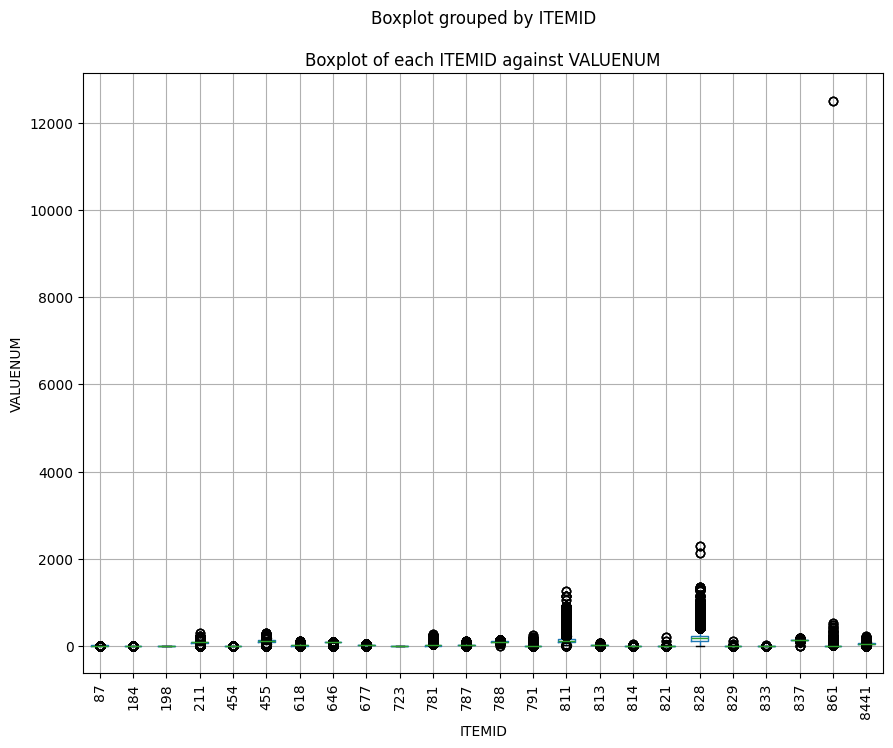

In [249]:
# create boxplot to understand retrieve data
chartevents_boxplot = chartevents_df.boxplot(column='VALUENUM', by='ITEMID', figsize=(10, 8), rot=90)
chartevents_boxplot.set_title("Boxplot of each ITEMID against VALUENUM")
chartevents_boxplot.set_xlabel("ITEMID")
chartevents_boxplot.set_ylabel("VALUENUM")

In [250]:
# state plausible limits if patients were alive
limits = {
    87: (6, 23), #braden score
    184: (1, 4), #eye opening
    198: (3, 15), #gcs total
    211: (25, 250), #heart rate
    454: (1, 6), #motor response
    455: (60, 250), #systolic bp
    618: (4, 60), #respiratory rate
    646: (50, 100), #sp02
    677: (32.0, 42.5), #temperature
    723: (1, 5), #verbal response
    781: (2, 120), #bun (blood urea nitrogen)
    787: (10, 45), #carbon dioxide
    788: (80, 130), #chloride
    791: (0.1, 15), #creatinine
    811: (30, 600), #glucose
    813: (15, 65), #hematocrit
    814: (4, 22), #hemoglobin
    821: (1.0, 4.5), #magnesium
    828: (20, 1200), #platelets
    829: (2.0, 7.0), #potassium
    833: (2.0, 7.5), #RBC
    837: (115, 170), #sodium
    861: (500, 200000) #wbc
}

In [251]:
# remove clinical outliers as errors
for item_id, (min, max), in limits.items():
  chartevents_df = chartevents_df[~((chartevents_df['ITEMID'] == item_id) & ((chartevents_df['VALUENUM'] < min) | (chartevents_df['VALUENUM'] > max)))]

In [252]:
# aggregate average value across hadm_id and item_id
chartevents_df = chartevents_df.groupby(['HADM_ID', 'ITEMID'])['VALUENUM'].mean().reset_index()

In [253]:
# pivot for a patient-wise view and produce final dataset
patient_pivot_avg_per_item_id_df = chartevents_df.pivot(index='HADM_ID', columns='ITEMID', values='VALUENUM').reset_index()
final_chartevents_df = patient_pivot_avg_per_item_id_df.reset_index(drop=True)

In [254]:
# rename all columns where not HADM_ID
final_chartevents_df= final_chartevents_df.rename(columns= lambda x: 'CHART_' + str(x) if x != "HADM_ID" else x)

In [255]:
# check final dataframe
final_chartevents_df.info()
final_chartevents_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17974 entries, 0 to 17973
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HADM_ID     17974 non-null  Int64  
 1   CHART_87    17052 non-null  float64
 2   CHART_184   17426 non-null  float64
 3   CHART_198   17414 non-null  float64
 4   CHART_211   17513 non-null  float64
 5   CHART_454   17416 non-null  float64
 6   CHART_455   15537 non-null  float64
 7   CHART_618   17472 non-null  float64
 8   CHART_646   17489 non-null  float64
 9   CHART_677   16278 non-null  float64
 10  CHART_723   17425 non-null  float64
 11  CHART_781   17201 non-null  float64
 12  CHART_787   17076 non-null  float64
 13  CHART_788   17099 non-null  float64
 14  CHART_791   17242 non-null  float64
 15  CHART_811   17465 non-null  float64
 16  CHART_813   17483 non-null  float64
 17  CHART_814   17016 non-null  float64
 18  CHART_821   16440 non-null  float64
 19  CHART_828   17187 non-nul

ITEMID,HADM_ID,CHART_87,CHART_184,CHART_198,CHART_211,CHART_454,CHART_455,CHART_618,CHART_646,CHART_677,CHART_723,CHART_781,CHART_787,CHART_788,CHART_791,CHART_811,CHART_813,CHART_814,CHART_821,CHART_828,CHART_829,CHART_833,CHART_837,CHART_861,CHART_8441
0,100006,16.125000,4.000000,15.000000,110.680000,6.000000,136.562500,19.000000,97.423077,36.409090,5.000000,14.000000,25.000000,102.000000,0.65,130.000000,30.500000,10.250,1.550000,194.5,4.050000,3.095,131.000000,NaN,77.666667
1,100007,15.000000,3.846154,14.230769,74.139535,6.000000,138.906977,16.613636,99.409091,36.716034,4.384615,13.000000,26.000000,106.500000,0.65,129.000000,35.299999,11.800,2.100000,228.5,4.400000,3.860,139.000000,NaN,61.046512
2,100017,18.000000,4.000000,14.000000,74.909091,6.000000,138.636364,16.090909,97.818182,37.416651,4.000000,10.000000,27.000000,104.000000,0.80,84.500000,41.400002,14.300,1.800000,173.0,4.000000,4.530,143.000000,NaN,56.272727
3,100030,18.166667,4.000000,15.000000,86.914286,6.000000,122.096774,25.454545,94.052632,37.196973,5.000000,9.500000,25.500000,99.500000,0.75,136.000000,40.549999,13.800,NaN,145.5,4.450000,4.725,134.000000,NaN,63.645161
4,100031,13.000000,2.666667,9.777778,79.283951,4.333333,119.611111,16.851351,99.433735,NaN,2.777778,18.500000,28.000000,105.000000,0.90,137.466667,26.714286,9.925,2.633333,161.5,4.630769,3.400,132.750000,NaN,43.388889
5,100033,17.333333,3.666667,12.666667,66.571429,6.000000,114.476190,14.809524,98.666667,36.412685,3.000000,13.000000,22.000000,110.000000,0.80,85.000000,42.400002,15.100,1.900000,181.0,3.900000,4.640,138.000000,NaN,59.000000
6,100038,18.000000,4.000000,15.000000,64.578947,6.000000,123.789474,22.842105,98.166667,36.629632,5.000000,42.000000,26.000000,106.000000,1.50,38.000000,27.799999,9.700,2.100000,381.0,4.300000,3.310,141.000000,NaN,61.578947
7,100041,12.000000,3.200000,11.600000,85.261905,5.000000,117.333333,12.000000,99.340909,36.925933,3.400000,18.000000,27.000000,107.000000,1.00,130.666667,26.860000,8.500,1.700000,140.0,4.420000,2.870,138.000000,NaN,50.000000
8,100045,12.333333,1.454545,6.166667,59.823529,3.833333,120.400000,17.140000,99.463415,36.944440,1.000000,35.500000,21.250000,98.000000,6.05,186.750000,27.971429,9.620,2.000000,88.2,3.900000,2.876,135.250000,NaN,45.140000
9,100046,13.000000,3.888889,14.111111,87.766667,6.000000,152.250000,18.750000,97.300000,37.033330,4.222222,11.666667,28.166667,104.166667,0.70,147.833333,31.500000,10.920,2.000000,129.2,3.116667,3.518,142.666667,NaN,65.357143


DATETTIMEEVENTS DATASET

In [256]:
# SQL query to select datetimeevents using SUBJECT_ID, HADM_ID within 48 hrs of admission
datetimeevents_query = f"""
SELECT *
FROM `physionet-data.mimiciii_clinical.datetimeevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.VALUE IS NOT NULL
"""

In [257]:
# load datetimeevents dataframe to memory
datetimeevents_df = load_file_results_to_df(query=datetimeevents_query, bucket=gcs_bucket, client=bq_client)
datetimeevents_df.info()
datetimeevents_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 2077143 row(s) has been returned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077143 entries, 0 to 2077142
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   ROW_ID        Int64         
 1   SUBJECT_ID    Int64         
 2   HADM_ID       Int64         
 3   ICUSTAY_ID    Int64         
 4   ITEMID        Int64         
 5   CHARTTIME     datetime64[us]
 6   STORETIME     datetime64[us]
 7   CGID          Int64         
 8   VALUE         datetime64[us]
 9   VALUEUOM      object        
 10  WARNING       Int64         
 11  ERROR         Int64         
 12  RESULTSTATUS  object        
 13  STOPPED       object        
 14  SUBJECT_ID_1  Int64         
 15  HADM_ID_1     Int64         
 16  ADMITTIME     datetime64[us]
dtypes: Int64(10), datetime64[us](4), object(3)
memory usage: 289.2+ MB


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SUBJECT_ID_1,HADM_ID_1,ADMITTIME
0,2438661,47466,196864,272761,226724,2131-07-11 08:35:00,2131-07-11 08:35:00,20889,2131-07-10 00:00:00,Date,0,0,None,None,47466,196864,2131-07-10 15:49:00
1,2438661,47466,196864,272761,226724,2131-07-11 08:35:00,2131-07-11 08:35:00,20889,2131-07-10 00:00:00,Date,0,0,None,None,47466,196864,2131-07-10 15:49:00
2,2438661,47466,196864,272761,226724,2131-07-11 08:35:00,2131-07-11 08:35:00,20889,2131-07-10 00:00:00,Date,0,0,None,None,47466,196864,2131-07-10 15:49:00
3,2765058,55545,131840,269671,224183,2169-04-09 05:00:00,2169-04-09 05:00:00,20924,2169-04-09 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
4,2765058,55545,131840,269671,224183,2169-04-09 05:00:00,2169-04-09 05:00:00,20924,2169-04-09 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
5,2765058,55545,131840,269671,224183,2169-04-09 05:00:00,2169-04-09 05:00:00,20924,2169-04-09 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
6,2765063,55545,131840,269671,224184,2169-04-09 08:40:00,2169-04-09 08:40:00,15405,2169-04-06 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
7,2765063,55545,131840,269671,224184,2169-04-09 08:40:00,2169-04-09 08:40:00,15405,2169-04-06 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
8,2765063,55545,131840,269671,224184,2169-04-09 08:40:00,2169-04-09 08:40:00,15405,2169-04-06 00:00:00,Date,0,0,None,None,55545,131840,2169-04-08 20:31:00
9,2765060,55545,131840,269671,224186,2169-04-09 05:00:00,2169-04-09 05:00:00,20924,2169-04-09 00:35:00,Date and Time,0,0,None,None,55545,131840,2169-04-08 20:31:00


In [258]:
# check how many have an error attributed
print(datetimeevents_df['ERROR'].value_counts())

ERROR
0    1464891
1         60
Name: count, dtype: Int64


In [259]:
# remove rows with attributed errors
datetimeevents_df = datetimeevents_df[datetimeevents_df['ERROR'] != 1]

In [260]:
# aggregate datetimeevent count
datetimeevents_counts_per_patient = datetimeevents_df.groupby(['SUBJECT_ID', 'HADM_ID']).size().reset_index(name='DATETIMEEVENTS_COUNT')
final_dateevents_df = datetimeevents_counts_per_patient
final_dateevents_df = final_dateevents_df.drop('SUBJECT_ID', axis=1, errors='ignore')

In [261]:
# check final dataframe
final_dateevents_df.info()
final_dateevents_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14626 entries, 0 to 14625
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   HADM_ID               14626 non-null  Int64
 1   DATETIMEEVENTS_COUNT  14626 non-null  int64
dtypes: Int64(1), int64(1)
memory usage: 242.9 KB


,HADM_ID,DATETIMEEVENTS_COUNT
0,170252,30
1,186251,33
2,100009,162
3,126769,60
4,166453,174
5,135882,27
6,142774,18
7,178493,21
8,115247,84
9,173495,27


LABEVENTS DATASET

In [262]:
# EXPLORE LABEVENTS DATAFRAME

# SQL query to select labevents based on subject_id, hadm_id and within 48 hours of admission
labevents_query = f"""
SELECT
  t.SUBJECT_ID,
  t.HADM_ID,
  COUNT(t.VALUE) as LAB_COUNT
FROM `physionet-data.mimiciii_clinical.labevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.VALUE IS NOT NULL OR t.VALUENUM IS NOT NULL
GROUP BY
  t.SUBJECT_ID,
  t.HADM_ID

"""

labevents_df = load_file_results_to_df(query=labevents_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 36128 row(s) has been returned.


In [263]:
# store to final dataframe and check dataframe
final_labevents_df = labevents_df
final_labevents_df = final_labevents_df.drop('SUBJECT_ID', axis=1, errors='ignore')
final_labevents_df.info()
final_labevents_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36128 entries, 0 to 36127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HADM_ID    36128 non-null  Int64
 1   LAB_COUNT  36128 non-null  Int64
dtypes: Int64(2)
memory usage: 635.2 KB


,HADM_ID,LAB_COUNT
0,171331,1347
1,118840,2307
2,153367,627
3,156639,1419
4,182035,6048
5,197901,873
6,112942,615
7,157489,4950
8,164766,1026
9,174575,1581


MICROBIOLOGYEVENTS DATASET

In [264]:
# EXPLORE MICROBIOLOGYEVENTS DATAFRAME

# SQL query to select microbiologyevents based on subject_id, hadm_id and within 48 hours of admission
microbiologyevents_query = f"""
SELECT
  t.SUBJECT_ID,
  t.HADM_ID,
  COUNT(*) as MICROLAB_COUNT
FROM `physionet-data.mimiciii_clinical.microbiologyevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.SPEC_ITEMID IS NOT NULL AND t.SPEC_TYPE_DESC IS NOT NULL
GROUP BY
  t.SUBJECT_ID,
  t.HADM_ID

"""

microbiologyevents_df = load_file_results_to_df(query=microbiologyevents_query, bucket=gcs_bucket, client=bq_client)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 22992 row(s) has been returned.


In [265]:
# store to final dataframe and check dataframe
final_microbiologyevents_df = microbiologyevents_df
final_microbiologyevents_df = final_microbiologyevents_df.drop('SUBJECT_ID', axis=1, errors='ignore')
final_microbiologyevents_df.head(10)

,HADM_ID,MICROLAB_COUNT
0,192120,60
1,171910,99
2,197098,153
3,188553,66
4,160831,90
5,169711,75
6,148929,84
7,152605,69
8,186417,66
9,136878,60


OUTPUTEVENTS DATASET

In [266]:
# SQL query to select outputevents based on subject_id, hadm_id and within 48 hours of admission

outputevents_query = f"""
SELECT
  t.ITEMID AS ITEMID,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.outputevents` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.VALUE IS NOT NULL
GROUP BY
  ITEMID
ORDER BY
  PATIENT_COUNT DESC
"""

In [267]:
# pull chartevents dataframe
outputevents_by_itemid_df = load_file_results_to_df(query=outputevents_query, bucket=gcs_bucket, client=bq_client)
outputevents_by_itemid_df = chartevents_by_itemid_df.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
pd.set_option('display.max_rows', None)
outputevents_by_itemid_df.head(100)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 421 row(s) has been returned.


,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL_x,LABEL_y
0,829,249321,17516,Potassium (3.5-5.3),Potassium (3.5-5.3)
1,211,2220465,17513,Heart Rate,Heart Rate
2,742,2204712,17506,calprevflg,calprevflg
3,646,2139750,17492,SpO2,SpO2
4,813,236388,17487,Hematocrit,Hematocrit
5,618,2152803,17472,Respiratory Rate,Respiratory Rate
6,811,297756,17469,Glucose (70-105),Glucose (70-105)
7,184,644085,17426,Eye Opening,Eye Opening
8,723,642327,17425,Verbal Response,Verbal Response
9,454,641367,17416,Motor Response,Motor Response


DIAGNOSES, MEDICATIONS AND PROCEDURES DATASETS

DIAGNOSES_ICD has not been included within preprocessing - out of scope.

INPUTEVENTS_CV & INPUTEVENTS_MV DATASETS


In [268]:
inputeventscv_query = f"""
SELECT
  t.ITEMID AS ITEMID,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.inputevents_cv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.AMOUNT IS NOT NULL
GROUP BY
  ITEMID
ORDER BY
  PATIENT_COUNT DESC
"""

In [269]:
# pull chartevents dataframe
inputeventscv_by_itemid_df = load_file_results_to_df(query=inputeventscv_query, bucket=gcs_bucket, client=bq_client)
inputeventscv_by_itemid_df = inputeventscv_by_itemid_df.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
inputeventscv_by_itemid_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 841 row(s) has been returned.


,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL
0,30013,1466892,15907,D5W
1,30018,1127199,12911,.9% Normal Saline
2,30056,155997,10710,Po Intake
3,30131,298974,6489,Propofol
4,30140,298326,6481,N/A
5,30026,193392,6459,KCL
6,30021,212778,5724,Lactated Ringers
7,30101,23298,4495,OR Crystalloid
8,30001,37953,4069,Packed RBC's
9,30054,15144,3599,Pre-Admission Intake


In [270]:
inputeventsmv_query = f"""
SELECT
  t.ITEMID AS ITEMID,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.inputevents_mv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.AMOUNT IS NOT NULL
GROUP BY
  ITEMID
ORDER BY
  PATIENT_COUNT DESC
"""

In [271]:
# pull inputeventsmv dataframe
inputeventsmv_by_itemid_df = load_file_results_to_df(query=inputeventsmv_query, bucket=gcs_bucket, client=bq_client)
inputeventsmv_by_itemid_df = inputeventsmv_by_itemid_df.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
inputeventsmv_by_itemid_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 227 row(s) has been returned.


,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL
0,225158,416178,11057,NaCl 0.9%
1,220949,252807,8998,Dextrose 5%
2,226452,110280,7751,PO Intake
3,225943,208095,7221,Solution
4,222011,25590,5342,Magnesium Sulfate
5,225166,55944,5103,Potassium Chloride
6,225975,37905,4753,Heparin Sodium (Prophylaxis)
7,223258,88866,4499,Insulin - Regular
8,222168,172710,4394,Propofol
9,225828,70254,4162,LR


In [272]:
# merge list and sum total value counts, sort descending
merged_lists = pd.concat([inputeventscv_by_itemid_df, inputeventsmv_by_itemid_df], ignore_index=True)
overall_list = merged_lists.groupby('ITEMID', as_index=False)[['ITEMID_COUNT', 'PATIENT_COUNT']].sum()
overall_list = overall_list.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
final_overall_list = overall_list.sort_values(by='PATIENT_COUNT', ascending=False)
final_overall_list.reset_index(drop=True).head(100)

,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL
0,30013,1466892,15907,D5W
1,30018,1127199,12911,.9% Normal Saline
2,225158,416178,11057,NaCl 0.9%
3,30056,155997,10710,Po Intake
4,220949,252807,8998,Dextrose 5%
5,226452,110280,7751,PO Intake
6,225943,208095,7221,Solution
7,30131,298974,6489,Propofol
8,30140,298326,6481,N/A
9,30026,193392,6459,KCL


In [273]:
top_inputevents_itemids = final_overall_list['ITEMID'].head(100).tolist()
print(top_inputevents_itemids)

[30013, 30018, 225158, 30056, 220949, 226452, 225943, 30131, 30140, 30026, 30021, 222011, 225166, 225975, 223258, 30101, 222168, 225828, 30001, 227523, 30054, 221456, 30045, 226089, 30015, 30128, 226361, 225154, 225798, 30144, 226364, 221744, 225907, 225910, 227522, 30121, 221794, 225168, 225799, 221749, 225850, 30025, 221668, 225974, 30005, 30102, 221833, 30120, 223262, 30020, 30118, 225823, 226453, 222056, 225152, 223260, 221906, 225942, 221385, 221828, 30095, 225893, 30043, 30124, 225834, 226372, 225884, 220864, 30055, 30050, 30059, 30065, 225855, 30006, 225944, 30104, 220970, 226368, 30142, 225851, 225859, 220995, 225911, 225833, 225159, 227689, 30060, 30112, 30029, 225879, 225832, 30119, 30030, 220952, 226363, 225170, 225830, 228315, 226365, 222042]


In [274]:
item_ids_str = ', '.join(str(i) for i in top_inputevents_itemids)

INPUTEVENTSCV DATASET

In [275]:
# SQL query to select rows from inputeventscv dataset based on subject_ids and hadm_ids within 48 hours of admissions

inputeventscv_query = f"""
SELECT
  t.HADM_ID,
  t.ITEMID,
  AVG(t.AMOUNT) as AVG_VAL
FROM `physionet-data.mimiciii_clinical.inputevents_cv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.CHARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.ITEMID IN ({item_ids_str})
  AND t.AMOUNT IS NOT NULL
GROUP BY
  t.HADM_ID,
  t.ITEMID

"""

In [276]:
# load dataframe
inputeventscv_by_itemid_df = load_file_results_to_df(query=inputeventscv_query, bucket=gcs_bucket, client=bq_client)
inputeventscv_by_itemid_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 115749 row(s) has been returned.


,HADM_ID,ITEMID,AVG_VAL
0,133997,30001,83.750000
1,170369,30001,49.133335
2,133691,30001,110.416667
3,153544,30001,136.333333
4,193082,30001,46.500000
5,168587,30001,118.500000
6,180310,30001,304.166667
7,150531,30001,81.758773
8,156042,30001,113.750000
9,116672,30001,676.250000


INPUTEVENTSMV DATASET

In [277]:
# SQL query to select rows from inputeventscv dataset based on subject_ids and hadm_ids within 48 hours of admission

inputeventsmv_query = f"""
SELECT
  t.HADM_ID,
  t.ITEMID,
  AVG(t.AMOUNT) as AVG_VAL
FROM `physionet-data.mimiciii_clinical.inputevents_mv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.ITEMID IN ({item_ids_str})
  AND t.AMOUNT IS NOT NULL
GROUP BY
  t.HADM_ID,
  t.ITEMID

"""

In [278]:
# load dataframe
inputeventsmv_by_itemid_df = load_file_results_to_df(query=inputeventsmv_query, bucket=gcs_bucket, client=bq_client)
inputeventsmv_by_itemid_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 148283 row(s) has been returned.


,HADM_ID,ITEMID,AVG_VAL
0,137488,220949,67.784088
1,109255,220949,64.580319
2,136328,220949,74.492639
3,182342,220949,210.728805
4,181183,220949,60.918730
5,148133,220949,40.164682
6,146765,220949,53.218149
7,193360,220949,92.992409
8,101659,220949,72.316782
9,154672,220949,27.398563


In [279]:
# merge returned lists and check for duplicates - in theory there should not be any as patients are recorded in different systems
merged_inputevents_by_itemid_df = pd.concat([inputeventscv_by_itemid_df, inputeventsmv_by_itemid_df], ignore_index=True)
duplicates_boolean = merged_inputevents_by_itemid_df.duplicated(subset=['HADM_ID', 'ITEMID']).any()
print('There are duplicate averages across datasets: ' + str(duplicates_boolean))

There are duplicate averages across datasets: False


In [280]:
# pivot and produce final dataset
patient_pivot_avg_per_inputevents_item_id_df = merged_inputevents_by_itemid_df.pivot(index='HADM_ID', columns='ITEMID', values='AVG_VAL').reset_index()
final_inputevents_df = patient_pivot_avg_per_inputevents_item_id_df

# rename all columns where not HADM_ID
final_inputevents_df = final_inputevents_df.rename(columns= lambda x: 'INPUT_' + str(x) if x != "HADM_ID" else x)
final_inputevents_df.info()
final_inputevents_df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30263 entries, 0 to 30262
Columns: 101 entries, HADM_ID to INPUT_228315
dtypes: Int64(1), float64(100)
memory usage: 23.3 MB


ITEMID,HADM_ID,INPUT_30001,INPUT_30005,INPUT_30006,INPUT_30013,INPUT_30015,INPUT_30018,INPUT_30020,INPUT_30021,INPUT_30025,INPUT_30026,INPUT_30029,INPUT_30030,INPUT_30043,INPUT_30045,INPUT_30050,INPUT_30054,INPUT_30055,INPUT_30056,INPUT_30059,INPUT_30060,INPUT_30065,INPUT_30095,INPUT_30101,INPUT_30102,INPUT_30104,INPUT_30112,INPUT_30118,INPUT_30119,INPUT_30120,INPUT_30121,INPUT_30124,INPUT_30128,INPUT_30131,INPUT_30140,INPUT_30142,INPUT_30144,INPUT_220864,INPUT_220949,INPUT_220952,INPUT_220970,INPUT_220995,INPUT_221385,INPUT_221456,INPUT_221668,INPUT_221744,INPUT_221749,INPUT_221794,INPUT_221828,INPUT_221833,INPUT_221906,INPUT_222011,INPUT_222042,INPUT_222056,INPUT_222168,INPUT_223258,INPUT_223260,INPUT_223262,INPUT_225152,INPUT_225154,INPUT_225158,INPUT_225159,INPUT_225166,INPUT_225168,INPUT_225170,INPUT_225798,INPUT_225799,INPUT_225823,INPUT_225828,INPUT_225830,INPUT_225832,INPUT_225833,INPUT_225834,INPUT_225850,INPUT_225851,INPUT_225855,INPUT_225859,INPUT_225879,INPUT_225884,INPUT_225893,INPUT_225907,INPUT_225910,INPUT_225911,INPUT_225942,INPUT_225943,INPUT_225944,INPUT_225974,INPUT_225975,INPUT_226089,INPUT_226361,INPUT_226363,INPUT_226364,INPUT_226365,INPUT_226368,INPUT_226372,INPUT_226452,INPUT_226453,INPUT_227522,INPUT_227523,INPUT_227689,INPUT_228315
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,10.000001,NaN,NaN,2.000000,NaN,NaN,NaN,14.663346,NaN,NaN,NaN,NaN,77.917209,58.75000,5.730406,NaN,NaN,NaN,NaN,478.768874,930.952374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,10.000000,49.999999,5.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.666667,NaN,NaN,NaN,NaN,NaN
1,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.158187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.764577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.452384,NaN,NaN,375.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,NaN,NaN,NaN,63.583333,NaN,112.750000,NaN,NaN,1050.000000,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,247.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,NaN,NaN,NaN,150.000000,120.967742,NaN,NaN,NaN,NaN,0.241935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.680178,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,20.000001,NaN,NaN,NaN,2.000000,NaN,1.457054,269.417264,9.010286,30.0,NaN,NaN,2.250000,10.773144,NaN,20.000000,NaN,NaN,1.000000,NaN,NaN,999.999960,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,26.941725,NaN,NaN,NaN,120.000000,NaN,NaN,3100.0,NaN,NaN,850.0,200.000000,NaN,49.999999,49.999999,NaN,NaN
5,100010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.999999,39.407920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.199667,NaN,NaN,375.000000,NaN,NaN,NaN,NaN,847.916656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,50.000000,NaN,NaN

PRESCRIPTIONS DATASET

In [281]:
# SQL query for extracting drugs taken based on subject_id, hadm_id within 48 hours of admission
prescriptions_query = f"""
SELECT
  t.DRUG AS ITEMID,
  t.FORMULARY_DRUG_CD,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.prescriptions` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTDATE BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.DOSE_VAL_RX IS NOT NULL
GROUP BY
  ITEMID,
  FORMULARY_DRUG_CD
ORDER BY
  PATIENT_COUNT DESC
"""

In [282]:
# load dataframe
prescriptions_drug_list_df = load_file_results_to_df(query=prescriptions_query, bucket=gcs_bucket, client=bq_client)
prescriptions_drug_list_df.head(100)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 4177 row(s) has been returned.


,ITEMID,FORMULARY_DRUG_CD,ITEMID_COUNT,PATIENT_COUNT
0,Sodium Chloride 0.9% Flush,NACLFLUSH,57705,15005
1,Insulin,INSULIN,45114,10920
2,Acetaminophen,ACET325,35553,10268
3,Heparin,HEPA5I,32529,8972
4,Docusate Sodium,DOCU100,28086,8540
5,Furosemide,FURO40I,43731,7673
6,Magnesium Sulfate,MAG2PM,39333,6911
7,Iso-Osmotic Dextrose,VANCOBASE,25026,6112
8,Magnesium Sulfate,MAGS1I,21801,5532
9,Potassium Chloride,KCL20PM,26757,5447


In [283]:
top_drugs_ids = prescriptions_drug_list_df['FORMULARY_DRUG_CD'].head(100).tolist()
print(top_drugs_ids)

['NACLFLUSH', 'INSULIN', 'ACET325', 'HEPA5I', 'DOCU100', 'FURO40I', 'MAG2PM', 'VANCOBASE', 'MAGS1I', 'KCL20PM', 'MICROK10', 'CALG1I', 'LR1000', 'PERC', 'LORA2I', 'NS1000', 'SENN187', 'D5W250', 'BISA10R', 'PANT40', 'MORP2I', 'KCLBASE2', 'DEX50SY', 'KCL20P', 'PROP100IG', 'NS500', 'NS500', 'NS100', 'NS250', 'KCL40I', 'VIAL', 'VANC1F', 'ONDAN4I', 'FRBD50', 'NS1000', 'METO25', 'RANI150', 'SW50', 'NS100', 'ALBU3H', 'METO25', 'MOM30L', 'PANT40I', 'METO5I', 'ASA81', 'ASA81EC', 'POTA20', 'KPHO45I', 'FENT2I', 'NEUT', 'ACET650R', 'DOCU100L', 'CHLO15L', 'IPRA2H', 'D545NS1000', 'GLUC1I', 'BAG50', 'METO5I', 'CALCG2/100NS', 'NS250', 'ISONACL', 'D5W250', 'NTGBASE', 'HEPBASE', 'METO10I', 'NS100CG', 'FAMO20PM', 'VANC1F', 'ASA325', 'BISA5', 'INHRIV', 'METO50', 'HEPPREMIX', 'MORP4I', 'PROP200IG', 'LORA5', 'KETO15I', 'PEPC20', 'KCL10PM', 'KCLBASE', 'HYDZ20I', 'METRBASE', 'NABC50I', 'HYDR1SYR', 'NEOSI', 'FURO20', 'GLAR100I', 'OXYC5', 'MVI', 'PHEN10I', 'KCL20/1000D51/2NS', 'HALD5I', 'AMBI5', 'CEFA10I', 'MEPE

In [284]:
# SQL query to select rows from prescriptions dataset based on subject_ids and hadm_ids within 48 hours of admission

prescriptions_query = f"""
SELECT
  t.HADM_ID,
  t.FORMULARY_DRUG_CD,
  COUNT(t.FORMULARY_DRUG_CD) as DRUG_COUNT
FROM `physionet-data.mimiciii_clinical.prescriptions` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTDATE BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.FORMULARY_DRUG_CD IN UNNEST({top_drugs_ids})
  AND t.DOSE_VAL_RX IS NOT NULL
GROUP BY
  t.HADM_ID,
  t.FORMULARY_DRUG_CD

"""

In [285]:
# load dataframe
prescriptions_df = load_file_results_to_df(query=prescriptions_query, bucket=gcs_bucket, client=bq_client)
prescriptions_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 350794 row(s) has been returned.


,HADM_ID,FORMULARY_DRUG_CD,DRUG_COUNT
0,116108,NS100,18
1,192890,NS100,24
2,124798,NS100,18
3,199087,NS100,18
4,133991,NS100,18
5,195950,NS100,18
6,128859,NS100,24
7,102672,NS100,21
8,176274,NS100,18
9,187502,NS100,21


In [286]:
# pivot and produce final dataset
patient_drugcounts_per_item_id_df = prescriptions_df.pivot(index='HADM_ID', columns='FORMULARY_DRUG_CD', values='DRUG_COUNT').reset_index()
final_prescriptions_df = patient_drugcounts_per_item_id_df

# rename and print preview
final_prescriptions_df = final_prescriptions_df.rename(columns= lambda x: 'DRUG_' + str(x) if x != "HADM_ID" else x)
final_prescriptions_df.info()
final_prescriptions_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31680 entries, 0 to 31679
Data columns (total 92 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   HADM_ID                 31680 non-null  Int64
 1   DRUG_ACET325            10272 non-null  Int64
 2   DRUG_ACET650R           2764 non-null   Int64
 3   DRUG_ALBU3H             3705 non-null   Int64
 4   DRUG_AMBI5              1497 non-null   Int64
 5   DRUG_APAP500            1424 non-null   Int64
 6   DRUG_ASA325             2272 non-null   Int64
 7   DRUG_ASA81              2939 non-null   Int64
 8   DRUG_ASA81EC            2909 non-null   Int64
 9   DRUG_BAG50              2587 non-null   Int64
 10  DRUG_BISA10R            4466 non-null   Int64
 11  DRUG_BISA5              2252 non-null   Int64
 12  DRUG_CALCG2/100NS       2553 non-null   Int64
 13  DRUG_CALG1I             5036 non-null   Int64
 14  DRUG_CEFA10I            1877 non-null   Int64
 15  DRUG_CHLO15L       

FORMULARY_DRUG_CD,HADM_ID,DRUG_ACET325,DRUG_ACET650R,DRUG_ALBU3H,DRUG_AMBI5,DRUG_APAP500,DRUG_ASA325,DRUG_ASA81,DRUG_ASA81EC,DRUG_BAG50,DRUG_BISA10R,DRUG_BISA5,DRUG_CALCG2/100NS,DRUG_CALG1I,DRUG_CEFA10I,DRUG_CHLO15L,DRUG_D545NS1000,DRUG_D5W250,DRUG_DEX50SY,DRUG_DOCU100,DRUG_DOCU100L,DRUG_FAMO20PM,DRUG_FENT2I,DRUG_FRBD50,DRUG_FURO20,DRUG_FURO40I,DRUG_GLAR100I,DRUG_GLUC1I,DRUG_HALD5I,DRUG_HEPA5I,DRUG_HEPBASE,DRUG_HEPPREMIX,DRUG_HYDR1SYR,DRUG_HYDZ20I,DRUG_INHRIV,DRUG_INSULIN,DRUG_IPRA2H,DRUG_ISONACL,DRUG_KCL10PM,DRUG_KCL20/1000D51/2NS,DRUG_KCL20P,DRUG_KCL20PM,DRUG_KCL40I,DRUG_KCLBASE,DRUG_KCLBASE2,DRUG_KETO15I,DRUG_KPHO45I,DRUG_LEVO4I,DRUG_LORA2I,DRUG_LORA5,DRUG_LR1000,DRUG_MAG2PM,DRUG_MAGS1I,DRUG_MEPE50I,DRUG_METO10I,DRUG_METO25,DRUG_METO50,DRUG_METO5I,DRUG_METRBASE,DRUG_MICROK10,DRUG_MOM30L,DRUG_MORP2I,DRUG_MORP4I,DRUG_MVI,DRUG_NABC50I,DRUG_NACLFLUSH,DRUG_NEOSI,DRUG_NEUT,DRUG_NS/MBP100I,DRUG_NS100,DRUG_NS1000,DRUG_NS100CG,DRUG_NS250,DRUG_NS500,DRUG_NTG100PM,DRUG_NTGBASE,DRUG_ONDAN4I,DRUG_OXYC5,DRUG_PANT40,DRUG_PANT40I,DRUG_PEPC20,DRUG_PERC,DRUG_PHEN10I,DRUG_POTA20,DRUG_PROP100IG,DRUG_PROP200IG,DRUG_RANI150,DRUG_SENN187,DRUG_SW50,DRUG_VANC1F,DRUG_VANCOBASE,DRUG_VIAL
0,100001,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9,<NA>,<NA>,3,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,6,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,12,<NA>,12,9,<NA>,<NA>,<NA>,3,<NA>,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,12,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
1,100003,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>
2,100006,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,6,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,100007,<NA>,6,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,3,<NA>,<NA>,3,<NA>,3,<NA>,<NA>,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,100009,3,3,<NA>,<NA>,<NA>,<NA>,3,3,3,<NA>,<NA>,<NA>,3,3,3,<NA>,9,3,3,3,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,3,6,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,3,<NA>,3,3,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,3,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>
5,100010,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,3,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,3,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,100011,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<N

PROCEDUREEVENTS_MV DATASET

In [287]:
procedureevents_mv_query = f"""
SELECT
  t.ITEMID,
  COUNT(*) AS ITEMID_COUNT,
  COUNT(DISTINCT t.SUBJECT_ID) AS PATIENT_COUNT
FROM `physionet-data.mimiciii_clinical.procedureevents_mv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.VALUE IS NOT NULL AND t.VALUE > 0
GROUP BY
  ITEMID
ORDER BY
  PATIENT_COUNT DESC
"""

In [288]:
# load dataframe
procedureevents_mv_df = load_file_results_to_df(query=procedureevents_mv_query, bucket=gcs_bucket, client=bq_client)
procedureevents_mv_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 114 row(s) has been returned.


,ITEMID,ITEMID_COUNT,PATIENT_COUNT
0,224275,37467,8086
1,224277,35940,7829
2,225752,18000,5318
3,225459,25638,5286
4,225792,16050,5077
5,225402,16902,4273
6,225966,9687,3138
7,227194,9348,2900
8,224276,11496,2842
9,224263,9546,2814


In [289]:
# merge with d_icd_procedures reference for insight
merged_procedureevents_counts_df = procedureevents_mv_df.merge(d_items_df[['ITEMID', 'LABEL']], on='ITEMID', how='left')
merged_procedureevents_counts_df

,ITEMID,ITEMID_COUNT,PATIENT_COUNT,LABEL
0,224275,37467,8086,20 Gauge
1,224277,35940,7829,18 Gauge
2,225752,18000,5318,Arterial Line
3,225459,25638,5286,Chest X-Ray
4,225792,16050,5077,Invasive Ventilation
5,225402,16902,4273,EKG
6,225966,9687,3138,Nasal Swab
7,227194,9348,2900,Extubation
8,224276,11496,2842,16 Gauge
9,224263,9546,2814,Multi Lumen


In [290]:
procedures_itemids = procedureevents_mv_df['ITEMID'].head(40).tolist()

In [291]:
# SQL query to select rows from prescriptions dataset based on subject_ids and hadm_ids within 48 hours of admission

procedureevents_mv_query = f"""
SELECT
  t.HADM_ID,
  t.ITEMID,
  COUNT(t.ITEMID) as EVENT_COUNT
FROM `physionet-data.mimiciii_clinical.procedureevents_mv` t
JOIN {full_dataset_path} i
  ON t.SUBJECT_ID = i.SUBJECT_ID
  AND t.HADM_ID = i.HADM_ID
WHERE t.STARTTIME BETWEEN i.ADMITTIME AND DATETIME_ADD(i.ADMITTIME, INTERVAL 48 HOUR)
  AND t.ITEMID IN UNNEST({procedures_itemids})
  AND t.VALUE IS NOT NULL
  AND t.CANCELREASON = 0
GROUP BY
  t.HADM_ID,
  t.ITEMID
"""

In [292]:
# load dataframe
procedureevents_mv_df = load_file_results_to_df(query=procedureevents_mv_query, bucket=gcs_bucket, client=bq_client)
procedureevents_mv_df.head(10)

Query executed and loaded to DataFrame using BigQuery
DataFrame with 73056 row(s) has been returned.


,HADM_ID,ITEMID,EVENT_COUNT
0,191230,225792,3
1,103165,225792,3
2,169488,224263,9
3,151323,224263,9
4,166106,224263,6
5,149750,224276,12
6,166106,225752,9
7,181420,224270,3
8,156896,224276,12
9,138495,224263,6


In [293]:
# pivot and produce final dataset
patient_procedureeventscounts_per_item_id_df = procedureevents_mv_df.pivot(index='HADM_ID', columns='ITEMID', values='EVENT_COUNT').reset_index()
final_procedureevents_df = patient_procedureeventscounts_per_item_id_df

# rename and print preview
final_procedureevents_df = final_procedureevents_df.rename(columns= lambda x: 'PROC_' + str(x) if x != "HADM_ID" else x)
final_procedureevents_df.info()
final_procedureevents_df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12885 entries, 0 to 12884
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   HADM_ID      12885 non-null  Int64
 1   PROC_221214  2527 non-null   Int64
 2   PROC_221216  747 non-null    Int64
 3   PROC_221217  1179 non-null   Int64
 4   PROC_221223  375 non-null    Int64
 5   PROC_223253  997 non-null    Int64
 6   PROC_224263  2813 non-null   Int64
 7   PROC_224264  681 non-null    Int64
 8   PROC_224267  1432 non-null   Int64
 9   PROC_224269  492 non-null    Int64
 10  PROC_224270  295 non-null    Int64
 11  PROC_224274  1724 non-null   Int64
 12  PROC_224275  8080 non-null   Int64
 13  PROC_224276  2838 non-null   Int64
 14  PROC_224277  7822 non-null   Int64
 15  PROC_224385  1419 non-null   Int64
 16  PROC_224560  955 non-null    Int64
 17  PROC_224566  265 non-null    Int64
 18  PROC_225202  269 non-null    Int64
 19  PROC_225400  372 non-null    Int64
 20  PROC_2

ITEMID,HADM_ID,PROC_221214,PROC_221216,PROC_221217,PROC_221223,PROC_223253,PROC_224263,PROC_224264,PROC_224267,PROC_224269,PROC_224270,PROC_224274,PROC_224275,PROC_224276,PROC_224277,PROC_224385,PROC_224560,PROC_224566,PROC_225202,PROC_225400,PROC_225401,PROC_225402,PROC_225430,PROC_225432,PROC_225439,PROC_225444,PROC_225451,PROC_225454,PROC_225459,PROC_225462,PROC_225469,PROC_225470,PROC_225752,PROC_225789,PROC_225792,PROC_225794,PROC_225966,PROC_227194,PROC_227712,PROC_228128,PROC_228129
0,100001,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,100003,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,100009,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,<NA>,6,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,3,<NA>,3,<NA>,3,<NA>,3,3,<NA>,<NA>,<NA>
3,100010,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,100011,3,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,3,9,<NA>,<NA>,<NA>,<NA>,3,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,<NA>,3,3,3,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,9
5,100016,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,100018,6,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,3,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,100024,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,3,<NA>,3,<NA>,3,<NA>,3,3,<NA>,3,6
8,100028,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3
9,100034,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,6,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6,<NA>,3,<NA>,3,<NA>,3,<NA>,3,3,<NA>,<NA>,<NA>


PROCEDURES_ICD DATASET

PROCEDURES_ICD has not been included within preprocessing - out of scope.

MERGING DATASET

In [294]:
# store names of datasets to be merged
datasets_to_merge = [final_patients_df, final_callout_df, final_icustays_df, final_chartevents_df,
                     final_dateevents_df, final_labevents_df, final_microbiologyevents_df,
                     final_inputevents_df, final_prescriptions_df, final_procedureevents_df]

In [295]:
# drop SUBJECT_ID column to avoid clash, join on HADM_ID
for df in datasets_to_merge:
  df = df.drop('SUBJECT_ID', axis=1, errors='ignore')

In [296]:
# import reduce tool for merging and merge, dropping unnecessary patient identifiers and admittime which is no longer required
from functools import reduce
overall_dataset_df = reduce(lambda left, right: pd.merge(left, right, on='HADM_ID', how='left'), datasets_to_merge)
overall_dataset_df = overall_dataset_df.drop(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME'], axis=1, errors='ignore')

In [297]:
# inspect missingness for new dataset
pd.set_option('display.max_rows', None)
overall_dataset_df.isnull().sum()

,0
ADMISSION_TYPE,0
ADMISSION_LOCATION,0
INSURANCE,0
LANGUAGE,0
RELIGION,0
MARITAL_STATUS,0
ETHNICITY,0
GENDER,0
EXPIRE_FLAG,0
AGE_YEARS,0


In [298]:
# inspect new datasdet
overall_dataset_df.info()
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')
overall_dataset_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36557 entries, 0 to 36556
Columns: 276 entries, ADMISSION_TYPE to PROC_228129
dtypes: Int64(135), float64(126), int64(2), object(13)
memory usage: 81.7+ MB


,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,EXPIRE_FLAG,AGE_YEARS,TOTAL_NO_CALLOUTS,CANCELLED_CALLOUTS,MRSA_REQ_MADE,TELE_REQ_MADE,RESP_REQ_MADE,CDIFF_REQ_MADE,VRE_REQ_MADE,TOTAL_ICUSTAYS,CHART_87,CHART_184,CHART_198,CHART_211,CHART_454,CHART_455,CHART_618,CHART_646,CHART_677,CHART_723,CHART_781,CHART_787,CHART_788,CHART_791,CHART_811,CHART_813,CHART_814,CHART_821,CHART_828,CHART_829,CHART_833,CHART_837,CHART_861,CHART_8441,DATETIMEEVENTS_COUNT,LAB_COUNT,MICROLAB_COUNT,INPUT_30001,INPUT_30005,INPUT_30006,INPUT_30013,INPUT_30015,INPUT_30018,INPUT_30020,INPUT_30021,INPUT_30025,INPUT_30026,INPUT_30029,INPUT_30030,INPUT_30043,INPUT_30045,INPUT_30050,INPUT_30054,INPUT_30055,INPUT_30056,INPUT_30059,INPUT_30060,INPUT_30065,INPUT_30095,INPUT_30101,INPUT_30102,INPUT_30104,INPUT_30112,INPUT_30118,INPUT_30119,INPUT_30120,INPUT_30121,INPUT_30124,INPUT_30128,INPUT_30131,INPUT_30140,INPUT_30142,INPUT_30144,INPUT_220864,INPUT_220949,INPUT_220952,INPUT_220970,INPUT_220995,INPUT_221385,INPUT_221456,INPUT_221668,INPUT_221744,INPUT_221749,INPUT_221794,INPUT_221828,INPUT_221833,INPUT_221906,INPUT_222011,INPUT_222042,INPUT_222056,INPUT_222168,INPUT_223258,INPUT_223260,INPUT_223262,INPUT_225152,INPUT_225154,INPUT_225158,INPUT_225159,INPUT_225166,INPUT_225168,INPUT_225170,INPUT_225798,INPUT_225799,INPUT_225823,INPUT_225828,INPUT_225830,INPUT_225832,INPUT_225833,INPUT_225834,INPUT_225850,INPUT_225851,INPUT_225855,INPUT_225859,INPUT_225879,INPUT_225884,INPUT_225893,INPUT_225907,INPUT_225910,INPUT_225911,INPUT_225942,INPUT_225943,INPUT_225944,INPUT_225974,INPUT_225975,INPUT_226089,INPUT_226361,INPUT_226363,INPUT_226364,INPUT_226365,INPUT_226368,INPUT_226372,INPUT_226452,INPUT_226453,INPUT_227522,INPUT_227523,INPUT_227689,INPUT_228315,DRUG_ACET325,DRUG_ACET650R,DRUG_ALBU3H,DRUG_AMBI5,DRUG_APAP500,DRUG_ASA325,DRUG_ASA81,DRUG_ASA81EC,DRUG_BAG50,DRUG_BISA10R,DRUG_BISA5,DRUG_CALCG2/100NS,DRUG_CALG1I,DRUG_CEFA10I,DRUG_CHLO15L,DRUG_D545NS1000,DRUG_D5W250,DRUG_DEX50SY,DRUG_DOCU100,DRUG_DOCU100L,DRUG_FAMO20PM,DRUG_FENT2I,DRUG_FRBD50,DRUG_FURO20,DRUG_FURO40I,DRUG_GLAR100I,DRUG_GLUC1I,DRUG_HALD5I,DRUG_HEPA5I,DRUG_HEPBASE,DRUG_HEPPREMIX,DRUG_HYDR1SYR,DRUG_HYDZ20I,DRUG_INHRIV,DRUG_INSULIN,DRUG_IPRA2H,DRUG_ISONACL,DRUG_KCL10PM,DRUG_KCL20/1000D51/2NS,DRUG_KCL20P,DRUG_KCL20PM,DRUG_KCL40I,DRUG_KCLBASE,DRUG_KCLBASE2,DRUG_KETO15I,DRUG_KPHO45I,DRUG_LEVO4I,DRUG_LORA2I,DRUG_LORA5,DRUG_LR1000,DRUG_MAG2PM,DRUG_MAGS1I,DRUG_MEPE50I,DRUG_METO10I,DRUG_METO25,DRUG_METO50,DRUG_METO5I,DRUG_METRBASE,DRUG_MICROK10,DRUG_MOM30L,DRUG_MORP2I,DRUG_MORP4I,DRUG_MVI,DRUG_NABC50I,DRUG_NACLFLUSH,DRUG_NEOSI,DRUG_NEUT,DRUG_NS/MBP100I,DRUG_NS100,DRUG_NS1000,DRUG_NS100CG,DRUG_NS250,DRUG_NS500,DRUG_NTG100PM,DRUG_NTGBASE,DRUG_ONDAN4I,DRUG_OXYC5,DRUG_PANT40,DRUG_PANT40I,DRUG_PEPC20,DRUG_PERC,DRUG_PHEN10I,DRUG_POTA20,DRUG_PROP100IG,DRUG_PROP200IG,DRUG_RANI150,DRUG_SENN187,DRUG_SW50,DRUG_VANC1F,DRUG_VANCOBASE,DRUG_VIAL,PROC_221214,PROC_221216,PROC_221217,PROC_221223,PROC_223253,PROC_224263,PROC_224264,PROC_224267,PROC_224269,PROC_224270,PROC_224274,PROC_224275,PROC_224276,PROC_224277,PROC_224385,PROC_224560,PROC_224566,PROC_225202,PROC_225400,PROC_225401,PROC_225402,PROC_225430,PROC_225432,PROC_225439,PROC_225444,PROC_225451,PROC_225454,PROC_225459,PROC_225462,PROC_225469,PROC_225470,PROC_225752,PROC_225789,PROC_225792,PROC_225794,PROC_225966,PROC_227194,PROC_227712,PROC_228128,PROC_228129
0,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,UKNO,CHRISTIAN,MARRIED,WHITE,M,1,76,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,11.200000,2.300000,7.666667,98.925373,4.444444,100.090909,16.679245,97.862069,36.777802,1.000000,40.500000,13.800000,111.000000,2.325000,219.909091,28.489474,9.250000,2.466667,240.000000,4.163636,3.072000,140.444444,NaN,41.909091,NaN,2886,24,375.0,NaN,NaN,23.543117,NaN,506.300000,100.000000,NaN,1190.277778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.409087,7.8125,NaN,1.007099,NaN,NaN,4.126755,NaN,NaN,NaN,52.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [299]:
# impute median for missing values
# build list of columns required for median imputation
median_columns = [col for col in overall_dataset_df.columns if col.startswith(('CHART', 'INPUT'))]

# impute median value for each ethnicity for every patient
for col in median_columns:
  overall_dataset_df[col] = overall_dataset_df.groupby('ETHNICITY')[col].transform(lambda x: x.fillna(x.median()))

In [300]:
# impute zero for missing values
# build list of columns required for zero-value imputation
zero_impute_columns = [col for col in overall_dataset_df.columns if col.startswith(('DRUG', 'PROC'))]

# impute zero value where there are missing values
for col in zero_impute_columns:
  overall_dataset_df[col] = overall_dataset_df[col].fillna(0)

In [301]:
overall_dataset_df.head(10)

,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,EXPIRE_FLAG,AGE_YEARS,TOTAL_NO_CALLOUTS,CANCELLED_CALLOUTS,MRSA_REQ_MADE,TELE_REQ_MADE,RESP_REQ_MADE,CDIFF_REQ_MADE,VRE_REQ_MADE,TOTAL_ICUSTAYS,CHART_87,CHART_184,CHART_198,CHART_211,CHART_454,CHART_455,CHART_618,CHART_646,CHART_677,CHART_723,CHART_781,CHART_787,CHART_788,CHART_791,CHART_811,CHART_813,CHART_814,CHART_821,CHART_828,CHART_829,CHART_833,CHART_837,CHART_861,CHART_8441,DATETIMEEVENTS_COUNT,LAB_COUNT,MICROLAB_COUNT,INPUT_30001,INPUT_30005,INPUT_30006,INPUT_30013,INPUT_30015,INPUT_30018,INPUT_30020,INPUT_30021,INPUT_30025,INPUT_30026,INPUT_30029,INPUT_30030,INPUT_30043,INPUT_30045,INPUT_30050,INPUT_30054,INPUT_30055,INPUT_30056,INPUT_30059,INPUT_30060,INPUT_30065,INPUT_30095,INPUT_30101,INPUT_30102,INPUT_30104,INPUT_30112,INPUT_30118,INPUT_30119,INPUT_30120,INPUT_30121,INPUT_30124,INPUT_30128,INPUT_30131,INPUT_30140,INPUT_30142,INPUT_30144,INPUT_220864,INPUT_220949,INPUT_220952,INPUT_220970,INPUT_220995,INPUT_221385,INPUT_221456,INPUT_221668,INPUT_221744,INPUT_221749,INPUT_221794,INPUT_221828,INPUT_221833,INPUT_221906,INPUT_222011,INPUT_222042,INPUT_222056,INPUT_222168,INPUT_223258,INPUT_223260,INPUT_223262,INPUT_225152,INPUT_225154,INPUT_225158,INPUT_225159,INPUT_225166,INPUT_225168,INPUT_225170,INPUT_225798,INPUT_225799,INPUT_225823,INPUT_225828,INPUT_225830,INPUT_225832,INPUT_225833,INPUT_225834,INPUT_225850,INPUT_225851,INPUT_225855,INPUT_225859,INPUT_225879,INPUT_225884,INPUT_225893,INPUT_225907,INPUT_225910,INPUT_225911,INPUT_225942,INPUT_225943,INPUT_225944,INPUT_225974,INPUT_225975,INPUT_226089,INPUT_226361,INPUT_226363,INPUT_226364,INPUT_226365,INPUT_226368,INPUT_226372,INPUT_226452,INPUT_226453,INPUT_227522,INPUT_227523,INPUT_227689,INPUT_228315,DRUG_ACET325,DRUG_ACET650R,DRUG_ALBU3H,DRUG_AMBI5,DRUG_APAP500,DRUG_ASA325,DRUG_ASA81,DRUG_ASA81EC,DRUG_BAG50,DRUG_BISA10R,DRUG_BISA5,DRUG_CALCG2/100NS,DRUG_CALG1I,DRUG_CEFA10I,DRUG_CHLO15L,DRUG_D545NS1000,DRUG_D5W250,DRUG_DEX50SY,DRUG_DOCU100,DRUG_DOCU100L,DRUG_FAMO20PM,DRUG_FENT2I,DRUG_FRBD50,DRUG_FURO20,DRUG_FURO40I,DRUG_GLAR100I,DRUG_GLUC1I,DRUG_HALD5I,DRUG_HEPA5I,DRUG_HEPBASE,DRUG_HEPPREMIX,DRUG_HYDR1SYR,DRUG_HYDZ20I,DRUG_INHRIV,DRUG_INSULIN,DRUG_IPRA2H,DRUG_ISONACL,DRUG_KCL10PM,DRUG_KCL20/1000D51/2NS,DRUG_KCL20P,DRUG_KCL20PM,DRUG_KCL40I,DRUG_KCLBASE,DRUG_KCLBASE2,DRUG_KETO15I,DRUG_KPHO45I,DRUG_LEVO4I,DRUG_LORA2I,DRUG_LORA5,DRUG_LR1000,DRUG_MAG2PM,DRUG_MAGS1I,DRUG_MEPE50I,DRUG_METO10I,DRUG_METO25,DRUG_METO50,DRUG_METO5I,DRUG_METRBASE,DRUG_MICROK10,DRUG_MOM30L,DRUG_MORP2I,DRUG_MORP4I,DRUG_MVI,DRUG_NABC50I,DRUG_NACLFLUSH,DRUG_NEOSI,DRUG_NEUT,DRUG_NS/MBP100I,DRUG_NS100,DRUG_NS1000,DRUG_NS100CG,DRUG_NS250,DRUG_NS500,DRUG_NTG100PM,DRUG_NTGBASE,DRUG_ONDAN4I,DRUG_OXYC5,DRUG_PANT40,DRUG_PANT40I,DRUG_PEPC20,DRUG_PERC,DRUG_PHEN10I,DRUG_POTA20,DRUG_PROP100IG,DRUG_PROP200IG,DRUG_RANI150,DRUG_SENN187,DRUG_SW50,DRUG_VANC1F,DRUG_VANCOBASE,DRUG_VIAL,PROC_221214,PROC_221216,PROC_221217,PROC_221223,PROC_223253,PROC_224263,PROC_224264,PROC_224267,PROC_224269,PROC_224270,PROC_224274,PROC_224275,PROC_224276,PROC_224277,PROC_224385,PROC_224560,PROC_224566,PROC_225202,PROC_225400,PROC_225401,PROC_225402,PROC_225430,PROC_225432,PROC_225439,PROC_225444,PROC_225451,PROC_225454,PROC_225459,PROC_225462,PROC_225469,PROC_225470,PROC_225752,PROC_225789,PROC_225792,PROC_225794,PROC_225966,PROC_227194,PROC_227712,PROC_228128,PROC_228129
0,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,UKNO,CHRISTIAN,MARRIED,WHITE,M,1,76,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,11.200000,2.300000,7.666667,98.925373,4.444444,100.090909,16.679245,97.862069,36.777802,1.000000,40.500000,13.800000,111.000000,2.325000,219.909091,28.489474,9.250000,2.466667,240.000000,4.163636,3.072000,140.444444,528.0,41.909091,NaN,2886,24,375.0,280.500000,233.0,23.543117,90.712500,506.300000,100.000000,250.000000,1190.277778,13.333333,2.805000,16.363636,19.810000,2.842093,3.229413,1500.0,518.0,140.000000,30.0,100.0,50.000000,10.00,1750.0,353.0,375.0,48.409

In [302]:
import numpy as np
# impute median for CHART_861 manually
overall_dataset_df['CHART_861'] = overall_dataset_df['CHART_861'].replace('NaN', np.nan)
overall_dataset_df['CHART_861'] = overall_dataset_df.groupby('ETHNICITY')['CHART_861'].transform(lambda x: x.fillna(528))
overall_dataset_df['CHART_861'].value_counts()

,count
CHART_861,
528.0,33711
12500.0,2846


In [303]:
# impute boolean columns with false where there is no data available
boolean_columns_to_impute = [col for col in overall_dataset_df.columns if col.endswith(('MADE'))]
print(boolean_columns_to_impute)

for col in boolean_columns_to_impute:
  overall_dataset_df[col] = overall_dataset_df[col].fillna(False)

['MRSA_REQ_MADE', 'TELE_REQ_MADE', 'RESP_REQ_MADE', 'CDIFF_REQ_MADE', 'VRE_REQ_MADE']


/tmp/ipython-input-303-3547542931.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  overall_dataset_df[col] = overall_dataset_df[col].fillna(False)


In [304]:
# impute callout / icustays columns with zero due to lack of data / no callouts
callout_columns_to_impute = ['TOTAL_NO_CALLOUTS', 'CANCELLED_CALLOUTS', 'TOTAL_ICUSTAYS', 'DATETIMEEVENTS_COUNT', 'LAB_COUNT', 'MICROLAB_COUNT']

for col in callout_columns_to_impute:
  overall_dataset_df[col] = overall_dataset_df[col].fillna(0)

In [305]:
# check that all missingness has been removed
pd.set_option('display.max_rows', None)
overall_dataset_df.isnull().sum()

,0
ADMISSION_TYPE,0
ADMISSION_LOCATION,0
INSURANCE,0
LANGUAGE,0
RELIGION,0
MARITAL_STATUS,0
ETHNICITY,0
GENDER,0
EXPIRE_FLAG,0
AGE_YEARS,0


In [306]:
# create a new target column - then store ethnicities and targets
overall_dataset_df['ETHNICITY_EXPIRE'] = overall_dataset_df['ETHNICITY'].astype(str) + "_" + overall_dataset_df['EXPIRE_FLAG'].astype(str)

# store ethnicities and expire flag and drop expire
ethnicities = overall_dataset_df['ETHNICITY']
expire_flags = overall_dataset_df['EXPIRE_FLAG']
ethnicity_expire_flag = overall_dataset_df['ETHNICITY_EXPIRE']

# drop unnecessary colums before one hot encoding
overall_dataset_df.drop(columns='EXPIRE_FLAG', axis=1, inplace=True, errors='ignore')

/tmp/ipython-input-306-1234816086.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  overall_dataset_df['ETHNICITY_EXPIRE'] = overall_dataset_df['ETHNICITY'].astype(str) + "_" + overall_dataset_df['EXPIRE_FLAG'].astype(str)


In [307]:
overall_dataset_df.head(10)

,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE_YEARS,TOTAL_NO_CALLOUTS,CANCELLED_CALLOUTS,MRSA_REQ_MADE,TELE_REQ_MADE,RESP_REQ_MADE,CDIFF_REQ_MADE,VRE_REQ_MADE,TOTAL_ICUSTAYS,CHART_87,CHART_184,CHART_198,CHART_211,CHART_454,CHART_455,CHART_618,CHART_646,CHART_677,CHART_723,CHART_781,CHART_787,CHART_788,CHART_791,CHART_811,CHART_813,CHART_814,CHART_821,CHART_828,CHART_829,CHART_833,CHART_837,CHART_861,CHART_8441,DATETIMEEVENTS_COUNT,LAB_COUNT,MICROLAB_COUNT,INPUT_30001,INPUT_30005,INPUT_30006,INPUT_30013,INPUT_30015,INPUT_30018,INPUT_30020,INPUT_30021,INPUT_30025,INPUT_30026,INPUT_30029,INPUT_30030,INPUT_30043,INPUT_30045,INPUT_30050,INPUT_30054,INPUT_30055,INPUT_30056,INPUT_30059,INPUT_30060,INPUT_30065,INPUT_30095,INPUT_30101,INPUT_30102,INPUT_30104,INPUT_30112,INPUT_30118,INPUT_30119,INPUT_30120,INPUT_30121,INPUT_30124,INPUT_30128,INPUT_30131,INPUT_30140,INPUT_30142,INPUT_30144,INPUT_220864,INPUT_220949,INPUT_220952,INPUT_220970,INPUT_220995,INPUT_221385,INPUT_221456,INPUT_221668,INPUT_221744,INPUT_221749,INPUT_221794,INPUT_221828,INPUT_221833,INPUT_221906,INPUT_222011,INPUT_222042,INPUT_222056,INPUT_222168,INPUT_223258,INPUT_223260,INPUT_223262,INPUT_225152,INPUT_225154,INPUT_225158,INPUT_225159,INPUT_225166,INPUT_225168,INPUT_225170,INPUT_225798,INPUT_225799,INPUT_225823,INPUT_225828,INPUT_225830,INPUT_225832,INPUT_225833,INPUT_225834,INPUT_225850,INPUT_225851,INPUT_225855,INPUT_225859,INPUT_225879,INPUT_225884,INPUT_225893,INPUT_225907,INPUT_225910,INPUT_225911,INPUT_225942,INPUT_225943,INPUT_225944,INPUT_225974,INPUT_225975,INPUT_226089,INPUT_226361,INPUT_226363,INPUT_226364,INPUT_226365,INPUT_226368,INPUT_226372,INPUT_226452,INPUT_226453,INPUT_227522,INPUT_227523,INPUT_227689,INPUT_228315,DRUG_ACET325,DRUG_ACET650R,DRUG_ALBU3H,DRUG_AMBI5,DRUG_APAP500,DRUG_ASA325,DRUG_ASA81,DRUG_ASA81EC,DRUG_BAG50,DRUG_BISA10R,DRUG_BISA5,DRUG_CALCG2/100NS,DRUG_CALG1I,DRUG_CEFA10I,DRUG_CHLO15L,DRUG_D545NS1000,DRUG_D5W250,DRUG_DEX50SY,DRUG_DOCU100,DRUG_DOCU100L,DRUG_FAMO20PM,DRUG_FENT2I,DRUG_FRBD50,DRUG_FURO20,DRUG_FURO40I,DRUG_GLAR100I,DRUG_GLUC1I,DRUG_HALD5I,DRUG_HEPA5I,DRUG_HEPBASE,DRUG_HEPPREMIX,DRUG_HYDR1SYR,DRUG_HYDZ20I,DRUG_INHRIV,DRUG_INSULIN,DRUG_IPRA2H,DRUG_ISONACL,DRUG_KCL10PM,DRUG_KCL20/1000D51/2NS,DRUG_KCL20P,DRUG_KCL20PM,DRUG_KCL40I,DRUG_KCLBASE,DRUG_KCLBASE2,DRUG_KETO15I,DRUG_KPHO45I,DRUG_LEVO4I,DRUG_LORA2I,DRUG_LORA5,DRUG_LR1000,DRUG_MAG2PM,DRUG_MAGS1I,DRUG_MEPE50I,DRUG_METO10I,DRUG_METO25,DRUG_METO50,DRUG_METO5I,DRUG_METRBASE,DRUG_MICROK10,DRUG_MOM30L,DRUG_MORP2I,DRUG_MORP4I,DRUG_MVI,DRUG_NABC50I,DRUG_NACLFLUSH,DRUG_NEOSI,DRUG_NEUT,DRUG_NS/MBP100I,DRUG_NS100,DRUG_NS1000,DRUG_NS100CG,DRUG_NS250,DRUG_NS500,DRUG_NTG100PM,DRUG_NTGBASE,DRUG_ONDAN4I,DRUG_OXYC5,DRUG_PANT40,DRUG_PANT40I,DRUG_PEPC20,DRUG_PERC,DRUG_PHEN10I,DRUG_POTA20,DRUG_PROP100IG,DRUG_PROP200IG,DRUG_RANI150,DRUG_SENN187,DRUG_SW50,DRUG_VANC1F,DRUG_VANCOBASE,DRUG_VIAL,PROC_221214,PROC_221216,PROC_221217,PROC_221223,PROC_223253,PROC_224263,PROC_224264,PROC_224267,PROC_224269,PROC_224270,PROC_224274,PROC_224275,PROC_224276,PROC_224277,PROC_224385,PROC_224560,PROC_224566,PROC_225202,PROC_225400,PROC_225401,PROC_225402,PROC_225430,PROC_225432,PROC_225439,PROC_225444,PROC_225451,PROC_225454,PROC_225459,PROC_225462,PROC_225469,PROC_225470,PROC_225752,PROC_225789,PROC_225792,PROC_225794,PROC_225966,PROC_227194,PROC_227712,PROC_228128,PROC_228129,ETHNICITY_EXPIRE
0,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,UKNO,CHRISTIAN,MARRIED,WHITE,M,76,0,0.0,False,False,False,False,False,1,11.200000,2.300000,7.666667,98.925373,4.444444,100.090909,16.679245,97.862069,36.777802,1.000000,40.500000,13.800000,111.000000,2.325000,219.909091,28.489474,9.250000,2.466667,240.000000,4.163636,3.072000,140.444444,528.0,41.909091,0.0,2886,24,375.0,280.500000,233.0,23.543117,90.712500,506.300000,100.000000,250.000000,1190.277778,13.333333,2.805000,16.363636,19.810000,2.842093,3.229413,1500.0,518.0,140.000000,30.0,100.0,50.000000,10.00,1750.0,353.0,37

In [308]:
overall_dataset_df['GENDER'].value_counts()

,count
GENDER,
M,21119
F,15438


In [309]:
categorical_columns = overall_dataset_df.select_dtypes(include=['object', 'category']).columns.tolist()
target_column = 'ETHNICITY_EXPIRE'
categorical_columns.remove(target_column)
numerical_columns = overall_dataset_df.select_dtypes(include=['Int64', 'int64', 'float64']).columns.tolist()
numerical_columns_to_scale = [x for x in numerical_columns if x != 'EXPIRE_FLAG']
boolean_columns = overall_dataset_df.select_dtypes(include='bool').columns.tolist()


# print columns to check
print("The categorical columns are:")
print(categorical_columns)
print("The boolean columns are:")
print(boolean_columns)
print("The numerical columns are:")
print(numerical_columns)
print("The numerical columns to scale are:")
print(numerical_columns_to_scale)
print("The target variable is:")
print(target_column)

The categorical columns are:
['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER']
The boolean columns are:
['MRSA_REQ_MADE', 'TELE_REQ_MADE', 'RESP_REQ_MADE', 'CDIFF_REQ_MADE', 'VRE_REQ_MADE']
The numerical columns are:
['AGE_YEARS', 'TOTAL_NO_CALLOUTS', 'CANCELLED_CALLOUTS', 'TOTAL_ICUSTAYS', 'CHART_87', 'CHART_184', 'CHART_198', 'CHART_211', 'CHART_454', 'CHART_455', 'CHART_618', 'CHART_646', 'CHART_677', 'CHART_723', 'CHART_781', 'CHART_787', 'CHART_788', 'CHART_791', 'CHART_811', 'CHART_813', 'CHART_814', 'CHART_821', 'CHART_828', 'CHART_829', 'CHART_833', 'CHART_837', 'CHART_861', 'CHART_8441', 'DATETIMEEVENTS_COUNT', 'LAB_COUNT', 'MICROLAB_COUNT', 'INPUT_30001', 'INPUT_30005', 'INPUT_30006', 'INPUT_30013', 'INPUT_30015', 'INPUT_30018', 'INPUT_30020', 'INPUT_30021', 'INPUT_30025', 'INPUT_30026', 'INPUT_30029', 'INPUT_30030', 'INPUT_30043', 'INPUT_30045', 'INPUT_30050', 'INPUT_30054', 'INPUT_30055', 'INPUT_30056', 'I

In [310]:
# get one hot encoding for categoric columns
categorical_cols_onehot = pd.get_dummies(overall_dataset_df[categorical_columns], dtype=int, drop_first=True)
categorical_cols_onehot.head(10)

,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_HMO REFERRAL/SICK,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER,ADMISSION_LOCATION_UNKNOWN,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,LANGUAGE_ENGL,LANGUAGE_OTHER,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SPAN,LANGUAGE_UKNO,RELIGION_CHRISTIAN,RELIGION_HINDU,RELIGION_JEWISH,RELIGION_MUSLIM,RELIGION_OTHER,RELIGION_UNKNOWN,MARITAL_STATUS_OTHER,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN,ETHNICITY_BLACK,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,ETHNICITY_WHITE,GENDER_M
0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
4,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
6,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
7,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [311]:
# prepare data to rejoin and drop index
categorical_cols_onehot = categorical_cols_onehot.reset_index(drop=True)
numerical_cols = overall_dataset_df[numerical_columns].reset_index(drop=True)
boolean_cols = overall_dataset_df[boolean_columns].reset_index(drop=True)
target_col = overall_dataset_df[target_column].reset_index(drop=True)

In [312]:
# encode target col
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
target_encoded = le.fit_transform(target_col)

for i, target_class in enumerate(le.classes_):
  print(f"The target class: {target_class} is now: {i}")

The target class: ASIAN_0 is now: 0
The target class: ASIAN_1 is now: 1
The target class: BLACK_0 is now: 2
The target class: BLACK_1 is now: 3
The target class: HISPANIC OR LATINO_0 is now: 4
The target class: HISPANIC OR LATINO_1 is now: 5
The target class: OTHER_0 is now: 6
The target class: OTHER_1 is now: 7
The target class: UNKNOWN_0 is now: 8
The target class: UNKNOWN_1 is now: 9
The target class: WHITE_0 is now: 10
The target class: WHITE_1 is now: 11


In [313]:
# covert array to dataframe
target_encoded = pd.DataFrame({'TARGET': target_encoded})
target_encoded.head(10)
print(len(target_encoded))

36557


In [314]:
# get final dataset
final_dataset = pd.concat([categorical_cols_onehot, boolean_cols, numerical_cols, target_encoded], axis=1)

# review final dataset
pd.set_option('display.max_rows', None)
final_dataset.info()
final_dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36557 entries, 0 to 36556
Columns: 301 entries, ADMISSION_TYPE_EMERGENCY to TARGET
dtypes: Int64(135), bool(5), float64(126), int64(35)
memory usage: 87.4 MB


,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_HMO REFERRAL/SICK,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER,ADMISSION_LOCATION_UNKNOWN,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,LANGUAGE_ENGL,LANGUAGE_OTHER,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SPAN,LANGUAGE_UKNO,RELIGION_CHRISTIAN,RELIGION_HINDU,RELIGION_JEWISH,RELIGION_MUSLIM,RELIGION_OTHER,RELIGION_UNKNOWN,MARITAL_STATUS_OTHER,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN,ETHNICITY_BLACK,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,ETHNICITY_WHITE,GENDER_M,MRSA_REQ_MADE,TELE_REQ_MADE,RESP_REQ_MADE,CDIFF_REQ_MADE,VRE_REQ_MADE,AGE_YEARS,TOTAL_NO_CALLOUTS,CANCELLED_CALLOUTS,TOTAL_ICUSTAYS,CHART_87,CHART_184,CHART_198,CHART_211,CHART_454,CHART_455,CHART_618,CHART_646,CHART_677,CHART_723,CHART_781,CHART_787,CHART_788,CHART_791,CHART_811,CHART_813,CHART_814,CHART_821,CHART_828,CHART_829,CHART_833,CHART_837,CHART_861,CHART_8441,DATETIMEEVENTS_COUNT,LAB_COUNT,MICROLAB_COUNT,INPUT_30001,INPUT_30005,INPUT_30006,INPUT_30013,INPUT_30015,INPUT_30018,INPUT_30020,INPUT_30021,INPUT_30025,INPUT_30026,INPUT_30029,INPUT_30030,INPUT_30043,INPUT_30045,INPUT_30050,INPUT_30054,INPUT_30055,INPUT_30056,INPUT_30059,INPUT_30060,INPUT_30065,INPUT_30095,INPUT_30101,INPUT_30102,INPUT_30104,INPUT_30112,INPUT_30118,INPUT_30119,INPUT_30120,INPUT_30121,INPUT_30124,INPUT_30128,INPUT_30131,INPUT_30140,INPUT_30142,INPUT_30144,INPUT_220864,INPUT_220949,INPUT_220952,INPUT_220970,INPUT_220995,INPUT_221385,INPUT_221456,INPUT_221668,INPUT_221744,INPUT_221749,INPUT_221794,INPUT_221828,INPUT_221833,INPUT_221906,INPUT_222011,INPUT_222042,INPUT_222056,INPUT_222168,INPUT_223258,INPUT_223260,INPUT_223262,INPUT_225152,INPUT_225154,INPUT_225158,INPUT_225159,INPUT_225166,INPUT_225168,INPUT_225170,INPUT_225798,INPUT_225799,INPUT_225823,INPUT_225828,INPUT_225830,INPUT_225832,INPUT_225833,INPUT_225834,INPUT_225850,INPUT_225851,INPUT_225855,INPUT_225859,INPUT_225879,INPUT_225884,INPUT_225893,INPUT_225907,INPUT_225910,INPUT_225911,INPUT_225942,INPUT_225943,INPUT_225944,INPUT_225974,INPUT_225975,INPUT_226089,INPUT_226361,INPUT_226363,INPUT_226364,INPUT_226365,INPUT_226368,INPUT_226372,INPUT_226452,INPUT_226453,INPUT_227522,INPUT_227523,INPUT_227689,INPUT_228315,DRUG_ACET325,DRUG_ACET650R,DRUG_ALBU3H,DRUG_AMBI5,DRUG_APAP500,DRUG_ASA325,DRUG_ASA81,DRUG_ASA81EC,DRUG_BAG50,DRUG_BISA10R,DRUG_BISA5,DRUG_CALCG2/100NS,DRUG_CALG1I,DRUG_CEFA10I,DRUG_CHLO15L,DRUG_D545NS1000,DRUG_D5W250,DRUG_DEX50SY,DRUG_DOCU100,DRUG_DOCU100L,DRUG_FAMO20PM,DRUG_FENT2I,DRUG_FRBD50,DRUG_FURO20,DRUG_FURO40I,DRUG_GLAR100I,DRUG_GLUC1I,DRUG_HALD5I,DRUG_HEPA5I,DRUG_HEPBASE,DRUG_HEPPREMIX,DRUG_HYDR1SYR,DRUG_HYDZ20I,DRUG_INHRIV,DRUG_INSULIN,DRUG_IPRA2H,DRUG_ISONACL,DRUG_KCL10PM,DRUG_KCL20/1000D51/2NS,DRUG_KCL20P,DRUG_KCL20PM,DRUG_KCL40I,DRUG_KCLBASE,DRUG_KCLBASE2,DRUG_KETO15I,DRUG_KPHO45I,DRUG_LEVO4I,DRUG_LORA2I,DRUG_LORA5,DRUG_LR1000,DRUG_MAG2PM,DRUG_MAGS1I,DRUG_MEPE50I,DRUG_METO10I,DRUG_METO25,DRUG_METO50,DRUG_METO5I,DRUG_METRBASE,DRUG_MICROK10,DRUG_MOM30L,DRUG_MORP2I,DRUG_MORP4I,DRUG_MVI,DRUG_NABC50I,DRUG_NACLFLUSH,DRUG_NEOSI,DRUG_NEUT,DRUG_NS/MBP100I,DRUG_NS100,DRUG_NS1000,DRUG_NS100CG,DRUG_NS250,DRUG_NS500,DRUG_NTG100PM,DRUG_NTGBASE,DRUG_ONDAN4I,DRUG_OXYC5,DRUG_PANT40,DRUG_PANT40I,DRUG_PEPC20,DRUG_PERC,DRUG_PHEN10I,DRUG_POTA20,DRUG_PROP100IG,DRUG_PROP200IG,DRUG_RANI150,DRUG_SENN187,DRUG_SW50,DRUG_VANC1F,DRUG_VANCOBASE,DRUG_VIAL,PROC_221214,PROC_221216,PROC_221217,PROC_221223,PROC_223253,PROC_224263,PROC_224264,PROC_224267,PROC_224269,PROC_224270,PROC_224274,PROC_224275,PROC_224276,PROC_224277,PROC_224385,PROC_224560,PROC_224566,PROC_225202,PROC_225400,PROC_225401,PROC_225402,PROC_225430,PROC_225432,PROC_225439,PROC_225444,PROC_225451,PROC_225454,PROC_225459,PROC_225462,PROC_225469,PROC_225470,PROC_225752,PROC_225789,PROC_225792,PROC_225794,PROC_225966,PROC_227194,PROC_227712,PROC_228128,PROC_228129,TARGET
0,1,0,1

In [315]:
# covert Int64 columns to int64 otherwise will fail when using SMOTE

for col in final_dataset.columns:
   if final_dataset[col].dtype =="Int64":
    final_dataset[col] = final_dataset[col].astype("int64")

In [316]:
# check final dtypes
final_dataset.dtypes

,0
ADMISSION_TYPE_EMERGENCY,int64
ADMISSION_TYPE_URGENT,int64
ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,int64
ADMISSION_LOCATION_HMO REFERRAL/SICK,int64
ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,int64
ADMISSION_LOCATION_TRANSFER,int64
ADMISSION_LOCATION_UNKNOWN,int64
INSURANCE_Medicaid,int64
INSURANCE_Medicare,int64
INSURANCE_Private,int64


In [324]:
from google.colab import drive
import pickle

drive.mount('/content/drive')
google_drive_path = '/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence Project/'

with open(google_drive_path + 'final_dataset.pkl', 'wb') as f:
  pickle.dump(final_dataset, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
